# TODO:

- Read TODOs
- Should we group mother’s and father’s qualification and occupations better?
- Find out which features should be protected: It may depend on the purpose: is the purpose to help students or not admit students?
- Fix documentation in the code
- Maybe implement FairPCA? The explainability may be less important if it is not used for admission rate, but only for giving the students the support they need
- Explainaability etc.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import scipy
import os

from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

# Functions
- Data Processing Functions
- Model Evaluation Functions
- Visualization Functions

## Data Processing Functions
- load_data()
- get_test_and_training_data(test_size=0.2)

In [3]:
## groups are right now 'mother_occupation' and 'Gender'
## HOW SHOULD WE LOAD THE DATA?
def load_data():
    predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
    df = predict_students_dropout_and_academic_success.data.features

    ## Remove Features related to Curricular units
    df = df[['Marital Status', 'Application mode', 'Application order', 'Course',
           'Daytime/evening attendance', 'Previous qualification',
           'Previous qualification (grade)',
           'Admission grade', 'Displaced', 'Educational special needs', 'Debtor',
           'Tuition fees up to date',
           'International', 'Unemployment rate',
           'Inflation rate', 'GDP',
           "Mother's qualification", "Father's qualification",
           "Mother's occupation", "Father's occupation",
           'Scholarship holder', 'Age at enrollment', 'Nacionality', 'Gender']]


    df_init = df.copy() # TODO: decide wether this is needed

    # Make a binary column for dropout
    data_y = predict_students_dropout_and_academic_success.data.targets
    data_y = data_y.Target.apply(lambda x: 1 if x == 'Dropout' else 0)
    df['Dropout'] = data_y

    # # Make a binary column for mother's and father's class based on their occupations
    # # TODO: check these idx
    # mother_upper_class_occupation = [
    #     1, 2, 122, 123, 125, 131, 132, 134, 141, 143, 144, 153, 173
    # ]
    # father_upper_class_occupations = [
    #     1, 2, 101, 112, 114, 121, 122, 123, 124, 131, 132, 134, 135, 141,
    #     143, 144, 151, 152, 153, 154, 161, 171, 172, 174, 175, 181, 182
    # ]

    # mother_occupation = np.asarray(df.mother_occupation)
    # mother_upper_class_values = [1 if occ in mother_upper_class_occupation else 0 for occ in mother_occupation]
    # father_occupation = np.asarray(df.father_occupation)
    # father_upper_class_values = [1 if occ in father_upper_class_occupations else 0 for occ in father_occupation]
    # df['mother_upper_class'] = mother_upper_class_values
    # df['father_upper_class'] = father_upper_class_values

    # # Remove "Mother's occupation" and "Father's occupation" columns
    # df.drop(columns=["Mother's occupation", "Father's occupation"], axis=1, inplace=True)

    # Make a binary column for portuguese
    nationality = np.asarray(df.Nacionality)
    is_portuguese_values = [1 if n == 1 else 0 for n in nationality]
    #df['is_portuguese'] = is_portuguese_values

    # Remove "Nacionality" columns
    #df.drop(columns=["Nacionality"], axis=1, inplace=True)


    #protected_cols = ['Gender', 'is_portuguese'] # TODO: do something with parents qualitifcation and occupation?? Or other categories
    protected_cols = ['Gender']

    labels = df[['Dropout']]
    groups = df[protected_cols]

    features_full = df.copy()
    df.drop('Dropout', axis=1, inplace=True)
    features = df.copy()
    features_protected = pd.concat([df[x] for x in protected_cols], axis=1)

    for x in protected_cols:
      df.drop(x, axis=1, inplace=True)

    features_np = df.copy()

    return features, features_full, labels, groups, features_np, features_protected, protected_cols


def get_test_and_training_data(features, labels, group, protected_cols=[], test_size=0.2): # take  group,  as arugment
    ## This code is adapted from solution to data debias exercises
    X, y = features, labels

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(X, y, group, test_size=test_size, random_state=seed)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, group, test_size=test_size, random_state=seed)

    # Subset for protected and non-protected features
    X_train_p = X_train[protected_cols]
    X_train_np = X_train.drop(columns=protected_cols)
    X_test_p = X_test[protected_cols]
    X_test_np = X_test.drop(columns=protected_cols)

    return X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np, group_train, group_test


### A Geometric Solution to Fair Representations

In [4]:
def debias_features(X, protected_idx, l=0):
    '''Based on exercises. Debias using de-correllation'''

    #FunctionTransfomer makes it an array and I want it to be a dataFrame
    X = pd.DataFrame(X) #This makes no difference

    X_p = X[protected_idx]
    X_np = X.drop(columns=protected_idx)

    # Find the basis from the protected attributes
    orthbasis = scipy.linalg.orth(X_p)

    # Debias nonprotected features by projecting them onto the basis
    X_np_debiased = X_np - orthbasis @ orthbasis.T @ X_np

    # Return debiased nonprotected features, tempered by lambda: r′_j(λ) = r_j + λ⋅ (x_j− r_j)
    return pd.DataFrame(X_np_debiased + l * (X_np - X_np_debiased))


## Model Evaluation Functions
- standard_scale
- cross_validator
- fairness metrics

In [5]:
def standard_scale(X_train, X_test): ## We need to scale within the cross val step to avoid data leakage
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train))
    X_test = pd.DataFrame(scaler.transform(X_test))
    return X_train, X_test

In [6]:
def cross_validator(model, X, y, protected_cols=[], n=5, debias=False, lambd=0):
    kfold = KFold(n, shuffle=True, random_state=seed)

    y_hat = np.zeros(len(y))

    for train_idx, test_idx in kfold.split(X, y): ## Split based on both X and y
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        X_train, X_test = standard_scale(X_train, X_test)
        if debias:
          protected_idx = [X.columns.get_loc(col) for col in protected_cols]
          X_train = debias_features(X_train, protected_idx, l=lambd) # using decorrelation
          X_test = X_test.drop(columns=protected_idx)

        model = model.fit(X_train, y_train)
        y_hat[test_idx] = model.predict(X_test)

    return y_hat

### Metrics



In [7]:
# Generates a dataframe for the purpose of computing fairness metrics
def make_df(y_test, y_pred, group_test):
    df = pd.DataFrame(y_pred, columns=['S'])
    #df = pd.DataFrame(model.predict(X_test), columns=['S'])
    df['G'] = group_test
    df['A'] = y_test
    return df

# g1 = MALE, g2 = FEMALE
def stat_parity(df):
    g1 = sum(df[df.G==0].S)/df[df.G==0].shape[0]
    g2 = sum(df[df.G==1].S)/df[df.G==1].shape[0]
    return g1, g2

def equal_odds(df, target=1):
    g1 = sum(df[(df.G==0)&(df.A==target)].S)/df[(df.G==0)&(df.A==target)].shape[0]
    g2 = sum(df[(df.G==1)&(df.A==target)].S)/df[(df.G==1)&(df.A==target)].shape[0]
    return g1, g2

def equal_outcomes(df, s=1):
    g1 = sum(df[(df.G==0)&(df.S==s)].A)/df[(df.G==0)&(df.S==s)].shape[0]
    g2 = sum(df[(df.G==1)&(df.S==s)].A)/df[(df.G==1)&(df.S==s)].shape[0]
    return g1, g2

def accuracy(df):
  tmp_df_g1 = df[(df['G'] == 0) & (df['A'].notna())]
  tmp_df_g2 = df[(df['G'] == 1) & (df['A'].notna())]
  g1 = accuracy_score(tmp_df_g1.A, tmp_df_g1.S)
  g2 = accuracy_score(tmp_df_g2.A, tmp_df_g2.S)
  return g1, g2


# Ceating dfs of the fairness metrics
## TODO: Add Accuracy... OR MAYBE USE ANOTHER METRIC
metric_names = ["stat_parity",
                "odds_t0",
                "odds_t1",
                "outcome_s0",
                "outcome_s1",
                "accuracy"
                ]

def metric_scores(y_test, y_pred, group_test, df = None):
    if df is None:
        df = make_df(y_test, y_pred, group_test)
    return [stat_parity(df),
           equal_odds(df, target=0),
           equal_odds(df, target=1),
           equal_outcomes(df, s=0),
           equal_outcomes(df, s=1),
           accuracy(df),
            ]

def metric_df(scores, group_names, names=metric_names):
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":group_names} # TODO: make the group name more general
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)

    return df_fair_metrics

## Visualization Functions

### Plot Correlation

In [8]:
def corr_mat(X, method='pearson'):
    '''The code is adapted from solution to data debias exercises
    Takes a dataframe and computes the correlations, and their
    statistical significance between all features,
    returning 2 arrays: correlations, and p_values'''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Compute correlation matrix
    n_features = X.shape[1]

    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))

    if method == 'pearson':
        corr_func = pearsonr
    elif method == 'spearman':
        corr_func = spearmanr
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = corr_func(X[:,i], X[:,j])
            corr_ = np.nan_to_num(corr_, 0)
            # Handle NaN values in correlation coefficient by setting p-value to 1
            if np.isnan(corr_[i,j]):
                p_[i,j] = 1

    return corr_, p_

def plot_corr(df, method='pearson', feature_cols=[], show_specific_features=False, num_corr=10):
    corr_name = ""
    if method == 'pearson':
        corr_name = "Pearson's "
    elif method == 'spearman':
        corr_name = "Spearman's "
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    corr, p = corr_mat(df, method)
    feature_idx = [df.columns.get_loc(col) for col in feature_cols]

    alpha = 0.05 # Significance level
    corrected_alpha = alpha / (df.shape[1]**2/2) #bonferronni correction


    if show_specific_features and len(feature_cols)==1:
      corr_spec_feature = corr[feature_idx[0]]

      features_sorted_spec_feature = [ y for x,y in sorted(zip(corr_spec_feature, features), key = lambda x: abs(x[0]), reverse = True)]
      corr_sorted_spec_feature = [ x for x,y in sorted(zip(corr_spec_feature, features), key = lambda x: abs(x[0]), reverse = True)]

      features_num_corr_spec_feature = features_sorted_spec_feature[1:(num_corr+1)]
      corr_num_corr_spec_feature = corr_sorted_spec_feature[1:(num_corr+1)]

      # Plot 10 highest correlations with specific feature
      x_pos = np.arange(len(features_num_corr_spec_feature))

      plt.figure(figsize=(8,6))

      colors = []
      for i in corr_num_corr_spec_feature:
          if i > 0:
              colors.append("#ffcea5")
          else:
              colors.append("#c9ffc7")


      for i in range(len(x_pos)):
          plt.bar(x_pos[i], corr_num_corr_spec_feature[i], color = colors[i], align='center')

      plt.xticks(x_pos, features_num_corr_spec_feature, rotation = 45, ha = 'right')
      plt.xlabel("Feature", fontsize = 12)
      plt.ylabel('Correlation', fontsize = 12)
      plt.title(f'All bonferroni p-values are significant (lower than 5%)', fontsize = 12)
      plt.suptitle(f'{feature_cols[0]}: {num_corr} highest {corr_name}correlations', fontsize = 14)

      plt.tight_layout()
      plt.show()


    else:
      if show_specific_features:
        plt.figure(figsize=(len(feature_cols),9))

        sns.heatmap(corr[:, feature_idx], cmap="coolwarm", xticklabels=df.columns[feature_idx], yticklabels=df.columns,
              mask = p[:, feature_idx]  > corrected_alpha, vmin=-1, vmax=1, square=True)
      else:
        plt.figure(figsize=(15,15))
        sns.heatmap(corr, cmap="coolwarm",
                    xticklabels=df.columns, yticklabels=df.columns,
                    square=True, vmin=-1, vmax=1, mask= p > corrected_alpha)



      plt.title(f"{corr_name}Correlation Coeff between all features (filtered by p > {alpha})")
      plt.show()

### Plot Feature

In [9]:
# Mapping of occupation codes to occupation names
occupation_names = {
    0: 'Student',
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    101: 'Armed Forces Officers', # Only Father
    102: 'Armed Forces Sergeants', # Only Father
    103: 'Other Armed Forces personnel', # Only Father
    112: 'Directors of administrative and commercial services', # Only Father
    114: 'Hotel, catering, trade and other services directors', # Only Father
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques', # Only Father
    122: 'Health professionals',
    123: 'Teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations', # Only Father
    125: 'Specialists in information and communication technologies (ICT)', # Only Mother
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians', # Only Father
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'Personal service workers',
    152: 'Sellers',
    153: 'Personal care workers and the like',
    154: 'Protection and security services personnel', # Only Father
    161: 'Market-oriented farmers and skilled agricultural and animal production workers', # Only Father
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence', # Only Father
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar', # Only Father
    174: 'Skilled workers in electricity and electronics', # Only Father
    173: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like', # Only Mother
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators', # Only Father
    182: 'Assembly workers', # Only Father
    183: 'Vehicle drivers and mobile equipment operators', # Only Father
    191: 'Cleaning workers', # Only Mother
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers' # Only Father
}

# TODO: I don't know if these categoreis should be changed, and check them though...
## 1: Unskilled Workers, 2: Skilled Workers, 3: Intermediate Level Technicians and Professions, 4: Administrative staff, Managers, and Specialists, 5: Managers, and Specialists, Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers
occupation_worker_levels = {
    0: 0,  # Student
    1: 5,  # Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers
    2: 3,  # Specialists in Intellectual and Scientific Activities
    3: 3,  # Intermediate Level Technicians and Professions
    4: 4,  # Administrative staff
    5: 2,  # Personal Services, Security and Safety Workers and Sellers
    6: 2,  # Farmers and Skilled Workers in Agriculture, Fisheries and Forestry
    7: 2,  # Skilled Workers in Industry, Construction and Craftsmen
    8: 2,  # Installation and Machine Operators and Assembly Workers
    9: 1,  # Unskilled Workers
    10: 2, # Armed Forces Professions
    90: 0, # Other Situation
    99: 0, # (blank)
    101: 2, # Armed Forces Officers
    102: 2, # Armed Forces Sergeants
    103: 2, # Other Armed Forces personnel
    112: 4, # Directors of administrative and commercial services
    114: 4, # Hotel, catering, trade and other services directors
    121: 3, # Specialists in the physical sciences, mathematics, engineering and related techniques
    122: 3, # Health professionals
    123: 3, # Teachers
    124: 4, # Specialists in finance, accounting, administrative organization, public and commercial relations
    125: 4, # Specialists in information and communication technologies (ICT)
    131: 3, # Intermediate level science and engineering technicians and professions
    132: 3, # Technicians and professionals, of intermediate level of health
    134: 3, # Intermediate level technicians from legal, social, sports, cultural and similar services
    135: 3, # Information and communication technology technicians
    141: 3, # Office workers, secretaries in general and data processing operators
    143: 3, # Data, accounting, statistical, financial services and registry-related operators
    144: 4, # Other administrative support staff
    151: 2, # Personal service workers
    152: 2, # Sellers
    153: 2, # Personal care workers and the like
    154: 2, # Protection and security services personnel
    161: 2, # Market-oriented farmers and skilled agricultural and animal production workers
    163: 2, # Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence
    171: 2, # Skilled construction workers and the like, except electricians
    172: 2, # Skilled workers in metallurgy, metalworking and similar
    174: 2, # Skilled workers in electricity and electronics
    173: 2, # Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like
    175: 2, # Workers in food processing, woodworking, clothing and other industries and crafts
    181: 2, # Fixed plant and machine operators
    182: 2, # Assembly workers
    183: 2, # Vehicle drivers and mobile equipment operators
    191: 1, # Cleaning workers
    192: 1, # Unskilled workers in agriculture, animal production, fisheries and forestry
    193: 1, # Unskilled workers in extractive industry, construction, manufacturing and transport
    194: 1, # Meal preparation assistants
    195: 2  # Street vendors (except food) and street service providers
}


# Mapping of qualification codes to qualification names
qualification_names = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: "Higher Education - Bachelor's Degree",
    3: 'Higher Education - Degree',
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    13: '2nd year complementary high school course', # Only Father
    14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    20: 'Complementary High School Course', # Only Father
    22: 'Technical-professional course',
    25: 'Complementary High School Course - not concluded',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    31: 'General Course of Administration and Commerce', # Only Father
    33: 'Supplementary Accounting and Administration', # Only Father
    34: 'Unknown',
    35: "Can't read or write",
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)',
}

# TODO: group this more correct
# Group -1: Others
# Group 0: No Education??
# Group 1: Basic Education,
# Group 2: Secondary Education
# Group 3: Higher Education (1st Cycle??)
# Group 4: Higher Education (Bachelor's Degree)
# Group 5: Higher Education (2nd Cycle??)
# Group 6: Higher Education (3rd Cycle??)


qualification_groups = {
    1: 1,   # Secondary Education - 12th Year of Schooling or Eq.
    2: 4,   # Higher Education - Bachelor's Degree
    3: 4,   # Higher Education - Degree
    4: 5,   # Higher Education - Master's
    5: 6,   # Higher Education - Doctorate
    6: -1,   # Frequency of Higher Education
    9: 1,   # 12th Year of Schooling - Not Completed
    10: 1,  # 11th Year of Schooling - Not Completed
    11: 1,  # 7th Year (Old)
    12: 1,  # Other - 11th Year of Schooling
    13: 2,  # 2nd year complementary high school course
    14: 1,  # 10th Year of Schooling
    18: 4,  # General commerce course
    19: 1,  # Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
    20: 1,  # Complementary High School Course
    22: 3,  # Technical-professional course
    25: 1,  # Complementary High School Course - not concluded
    26: 1,  # 7th year of schooling
    27: 1,  # 2nd cycle of the general high school course
    29: 1,  # 9th Year of Schooling - Not Completed
    30: 1,  # 8th year of schooling
    31: 4,  # General Course of Administration and Commerce
    33: 4,  # Supplementary Accounting and Administration
    34: -1,  # Unknown
    35: 0,  # Can't read or write
    36: 0,  # Can read without having a 4th year of schooling
    37: 1,  # Basic education 1st cycle (4th/5th year) or equiv.
    38: 1,  # Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.
    39: 3,  # Technological specialization course
    40: 4,  # Higher education - degree (1st cycle)
    41: 4,  # Specialized higher studies course
    42: 4,  # Professional higher technical course
    43: 5,  # Higher Education - Master (2nd cycle)
    44: 6   # Higher Education - Doctorate (3rd cycle)
}


# Mother's and Father's qualification
education_levels = {
    34: 0,  # Unknown
    35: 1,  # Can't read or write
    36: 2,  # Can read without having a 4th year of schooling
    37: 3,  # Basic education 1st cycle (4th/5th year) or equiv.
    38: 4,  # Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.
    19: 5,  # Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
    14: 6,  # 10th Year of Schooling
    10: 7,  # 11th Year of Schooling - Not Completed
    9: 8,   # 12th Year of Schooling - Not Completed
    1: 9,   # Secondary Education - 12th Year of Schooling or Eq.
    26: 10, # 7th year of schooling
    30: 11, # 8th year of schooling
    25: 12, # Complementary High School Course - not concluded
    20: 13, # Complementary High School Course
    27: 14, # 2nd cycle of the general high school course
    13: 15, # 2nd year complementary high school course
    22: 16, # Technical-professional course
    18: 17, # General commerce course
    31: 18, # General Course of Administration and Commerce
    33: 19, # Supplementary Accounting and Administration
    39: 20, # Technological specialization course
    40: 21, # Higher education - degree (1st cycle)
    2: 22,  # Higher Education - Bachelor's Degree
    3: 23,  # Higher Education - Degree
    4: 24,  # Higher Education - Master's
    43: 25, # Higher Education - Master (2nd cycle)
    5: 26,  # Higher Education - Doctorate
    44: 27, # Higher Education - Doctorate (3rd cycle)
    6: 28,  # Frequency of Higher Education
    41: 29, # Specialized higher studies course
    42: 30  # Professional higher technical course
}

course_names = {
    33: 'Biofuel Production Technologies',
    171: 'Animation and Multimedia Design',
    8014: 'Social Service (evening attendance)',
    9003: 'Agronomy',
    9070: 'Communication Design',
    9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering',
    9130: 'Equinculture',
    9147: 'Management',
    9238: 'Social Service',
    9254: 'Tourism',
    9500: 'Nursing',
    9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management',
    9773: 'Journalism and Communication',
    9853: 'Basic Education',
    9991: 'Management (evening attendance)'
}

In [10]:
def plot_feature(feature_name, feature_mapping, features_full, column_feature='Dropout', colors=['#c9ffc7', '#ffcea5'], show_ratio=True, labels=['No', 'Yes']):
  # Data
  tmp_full_features = features_full.copy()
  tmp_full_features[feature_name] = tmp_full_features[feature_name].map(feature_mapping)
  counts = tmp_full_features.groupby([feature_name, column_feature]).size().unstack(fill_value=0)

  # Calculate column_feature ratio
  if show_ratio:
    counts[f'{column_feature} Ratio'] = counts[1] / (counts[0] + counts[1])

  # Plotting
  fig, ax1 = plt.subplots(figsize=(12, 8))

  # Plotting column_feature counts
  bar_width = 0.35
  positions = np.arange(len(counts))

  ax1.bar(positions - bar_width/2, counts[1], width=bar_width, color=colors[1], label=labels[1])
  ax1.bar(positions + bar_width/2, counts[0], width=bar_width, color=colors[0], label=labels[0])
  ax1.set_ylabel('Number of Students', color='black')
  ax1.tick_params(axis='y', labelcolor='black')
  ax1.set_xticks(positions)
  ax1.set_xticklabels(counts.index, rotation=90, ha='center')
  ax1.legend(title=column_feature, loc='upper left')

  # Creating a second y-axis for column_feature ratio
  if show_ratio:
    ax2 = ax1.twinx()
    ax2.plot(positions, counts[f'{column_feature} Ratio'], color='red', marker='o', linestyle='-')
    ax2.set_ylabel(f'{column_feature} Ratio', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f"Distribution of {feature_name} and {column_feature} Ratio")
  else:
    plt.title(f"Distribution of {feature_name} by {column_feature}")

  plt.tight_layout()
  plt.show()


### Model Evaluation Plots

In [11]:
def plot_scores_and_group(df, title=None):
  # Plotting
  fig, ax = plt.subplots(figsize=(10, 6))
  #groups = df['group'].unique()
  metrics = df['metric'].unique()
  bar_width = 0.35
  index = range(len(metrics))

  color_palette = sns.color_palette("pastel", n_colors=len(df['group'].unique()))


  for i, group in enumerate(df['group'].unique()):
      values = df[df['group'] == group]['score']
      ax.bar([x + i * bar_width for x in index], values, bar_width, label=group, color=color_palette[i])

  ax.set_xlabel('Metric')
  ax.set_ylabel('Score')
  if title:
    ax.set_title(title)
  else:
    ax.set_title('Scores by Metric and Group')
  ax.set_xticks([x + bar_width for x in index])
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.tight_layout()
  plt.show()

def plot_scores_and_group_compare(df1, df2, titles=None):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)  # Create subplots side by side

    # Iterate over DataFrames
    for i, (ax, df) in enumerate(zip(axes, [df1, df2])):
        metrics = df['metric'].unique()
        bar_width = 0.35
        index = range(len(metrics))

        color_palette = sns.color_palette("pastel", n_colors=len(df['group'].unique()))

        for j, group in enumerate(df['group'].unique()):
            values = df[df['group'] == group]['score']
            ax.bar([x + j * bar_width for x in index], values, bar_width, label=group, color=color_palette[j])

        ax.set_xlabel('Metric')
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title('Scores by Metric and Group')

        ax.set_xticks([x + bar_width for x in index])
        ax.set_xticklabels(metrics)

    # Set common y-label and legend
    axes[0].set_ylabel('Score')
    axes[0].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Load Data

In [12]:
features, features_full, labels, groups, features_np, features_p, protected_cols = load_data()
X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np, group_train, group_test = get_test_and_training_data(features, labels, groups['Gender'], protected_cols=protected_cols)

# Exploratory Data Analysis (EDA)

In [13]:
features_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.00,1.0,1.00,1.00,6.00
Application mode,4424.0,18.669078,17.484682,1.00,1.0,17.00,39.00,57.00
Application order,4424.0,1.727848,1.313793,0.00,1.0,1.00,2.00,9.00
Course,4424.0,8856.642631,2063.566416,33.00,9085.0,9238.00,9556.00,9991.00
Daytime/evening attendance,4424.0,0.890823,0.311897,0.00,1.0,1.00,1.00,1.00
Previous qualification,4424.0,4.577758,10.216592,1.00,1.0,1.00,1.00,43.00
Previous qualification (grade),4424.0,132.613314,13.188332,95.00,125.0,133.10,140.00,190.00
Admission grade,4424.0,126.978119,14.482001,95.00,117.9,126.10,134.80,190.00
Displaced,4424.0,0.548373,0.497711,0.00,0.0,1.00,1.00,1.00
Educational special needs,4424.0,0.011528,0.106760,0.00,0.0,0.00,0.00,1.00


## Imbalance in Dropout

Number of rows with dropout is 1421, corresponding to 32.12 % of the data
Number of rows with dropout is 3003, corresponding to 67.88 % of the data
Imbalance Ratio (IR) is 2.11



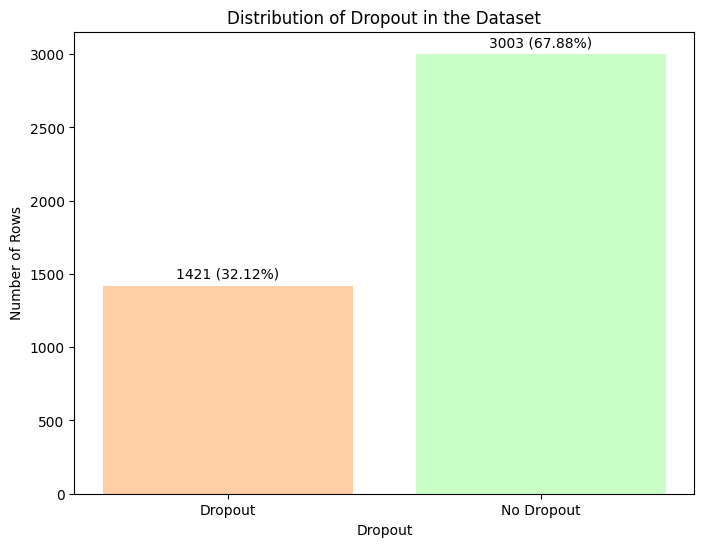

In [14]:
# Data
rows_dropout = len(features_full[features_full.Dropout == 1].index)
rows_not_dropout = len(features_full[features_full.Dropout == 0].index)
total_rows = len(features_full)

# Calculate percentages
dropout_percentage = 100 * rows_dropout / total_rows
not_dropout_percentage = 100 * rows_not_dropout / total_rows


print(f"Number of rows with dropout is {rows_dropout}, corresponding to {np.round(100 * rows_dropout/len(features_full),2)} % of the data")
print(f"Number of rows with dropout is {rows_not_dropout}, corresponding to {np.round(100 * rows_not_dropout/len(features_full),2)} % of the data")

print(f"Imbalance Ratio (IR) is {np.round(rows_not_dropout/rows_dropout,2)}\n")

# Plotting
labels = ['Dropout', 'No Dropout']
values = [rows_dropout, rows_not_dropout]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['#ffcea5', '#c9ffc7'])
plt.xlabel('Dropout')
plt.ylabel('Number of Rows')
plt.title('Distribution of Dropout in the Dataset')

# Add percentages on top of bars
for i in range(len(labels)):
    plt.text(i, values[i] + 50, f'{values[i]} ({np.round(100 * values[i]/total_rows, 2)}%)', ha='center')

plt.show()

## Representations bias: higher education institution with a majority of females are overrepresented

In Portugal, 49% of 25-34 year-old women had a tertiary qualification in 2020 compared to 35% of their male peers.


https://www.oecd-ilibrary.org/sites/db0e552c-en/index.html?itemId=/content/component/db0e552c-en

The higher imbalance ratio in our dataset compared to OECD data could be attributed to the composition of higher education institutions. For instance, programs like Nursing and Veterinary Nursing, which typically enroll a higher number of females, may contribute to this imbalance. Conversely, fields such as Law Enforcement Studies and more technical courses, which tend to attract more males, might not be represented in our dataset, further skewing the gender distribution.

OECD Imbalance Ratio (IR) is 1.4
Number of rows with male is 1556, corresponding to 35.17 % of the data
Number of rows with female is 2868, corresponding to 64.83 % of the data
Dataset Imbalance Ratio (IR) is 1.84



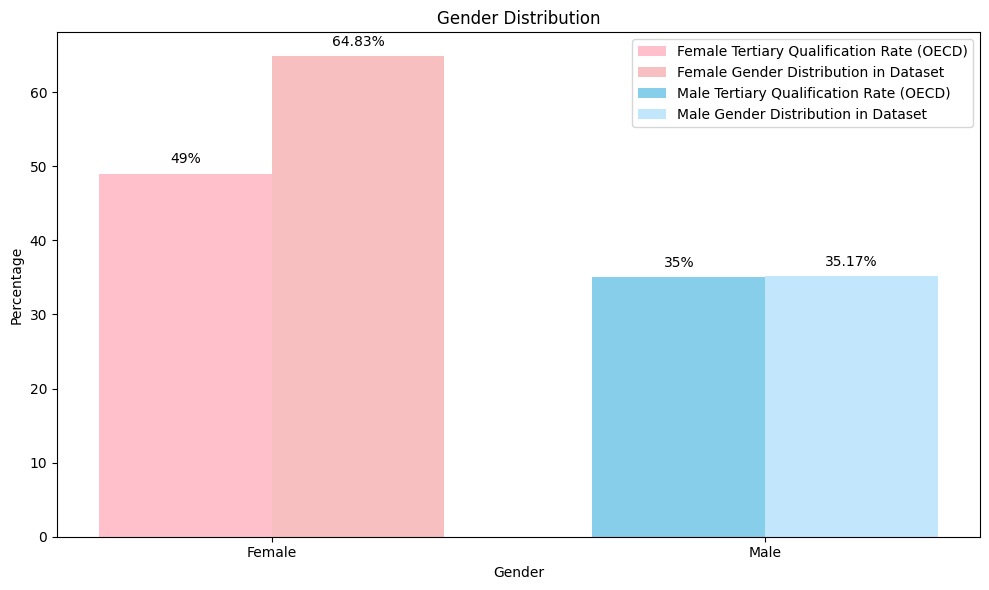

In [15]:
# OECD Data
female_tertiary = 49  # percentage of 25-34 year-old women with tertiary qualification
male_tertiary = 35    # percentage of 25-34 year-old men with tertiary qualification

print(f"OECD Imbalance Ratio (IR) is {np.round(female_tertiary/male_tertiary,2)}")

# Data: Calculate percentages
rows_male = len(features_full[features_full.Gender == 1].index)
rows_female = len(features_full[features_full.Gender == 0].index)
total_rows = len(features_full)

male_percentage = 100 * rows_male / total_rows
female_percentage = 100 * rows_female / total_rows
print(f"Number of rows with male is {rows_male}, corresponding to {np.round(100 * rows_male/len(features_full),2)} % of the data")
print(f"Number of rows with female is {rows_female}, corresponding to {np.round(100 * rows_female/len(features_full),2)} % of the data")
print(f"Dataset Imbalance Ratio (IR) is {np.round(rows_female/rows_male,2)}\n")

labels_data = ['Male', 'Female']
values_data = [rows_male, rows_female]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

# Bar plot for female tertiary qualification rates
bar1 = ax.bar(index[0] - bar_width/2, female_tertiary, bar_width, color='pink', label='Female Tertiary Qualification Rate (OECD)')
bar2 = ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='lightcoral', alpha=0.5, label='Female Gender Distribution in Dataset')
bar3 = ax.bar(index[1] - bar_width/2, male_tertiary, bar_width, color='skyblue', label='Male Tertiary Qualification Rate (OECD)')
bar4 = ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='lightskyblue', alpha=0.5, label='Male Gender Distribution in Dataset')

ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution')
ax.set_xticks(index)
ax.set_xticklabels(['Female', 'Male'])
ax.legend()

# Add text annotations
ax.text(index[0] - bar_width/2, female_tertiary + 1, f'{female_tertiary}%', ha='center', va='bottom')
ax.text(index[1] - bar_width/2, male_tertiary + 1, f'{male_tertiary}%', ha='center', va='bottom')
ax.text(index[0] + bar_width/2, female_percentage + 1, f'{np.round(female_percentage,2)}%', ha='center', va='bottom')
ax.text(index[1] + bar_width/2, male_percentage + 1, f'{np.round(male_percentage,2)}%', ha='center', va='bottom')


plt.tight_layout()
plt.show()


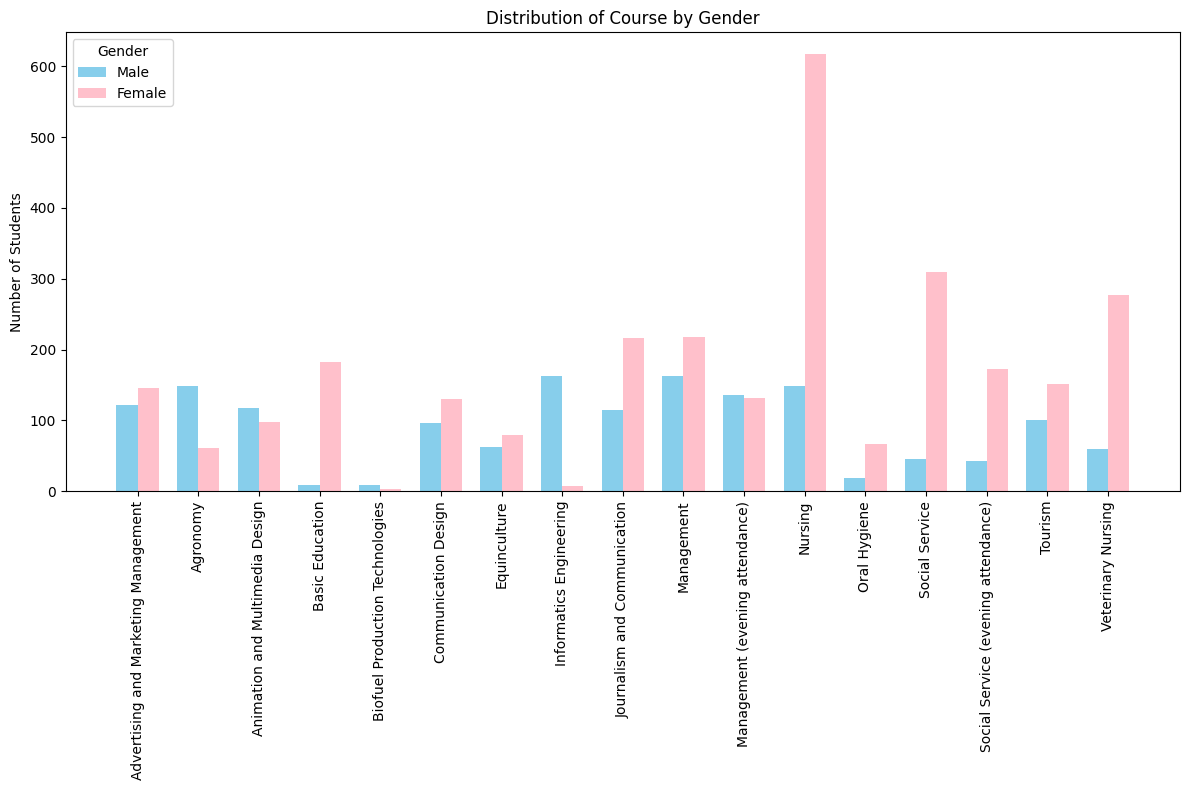

In [16]:
feature_name = "Course"
plot_feature(feature_name, course_names, features_full, column_feature='Gender', colors=['pink', 'skyblue'], labels=['Female', 'Male'], show_ratio=False)

## Social Inheritance? and data representation bias?

- Parent's ualification is hard to conclude on as the data is kind of imbalanced
- Parents' occupation seems to have more influence, and is easier to conclude on as the groups seems to be a bit more balanced.

It seems to show that the drop out ratio is the highest if the student have parents in worker class 0.

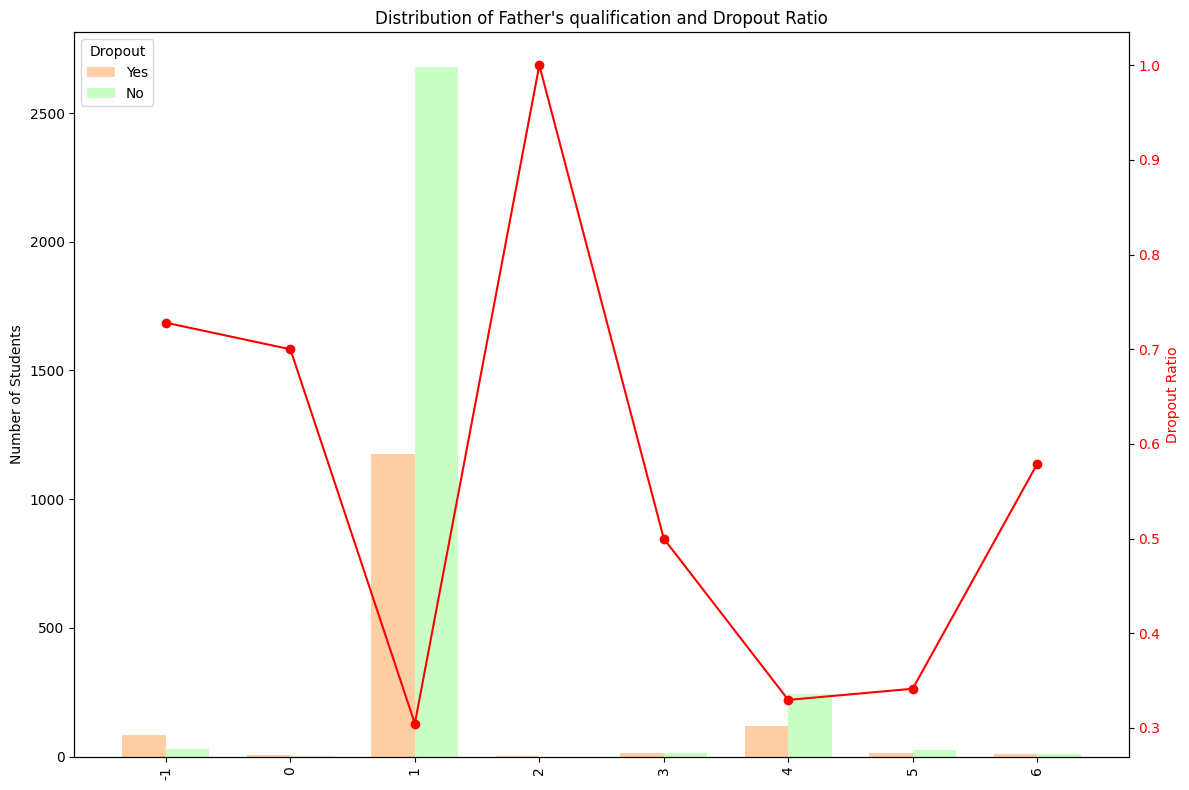

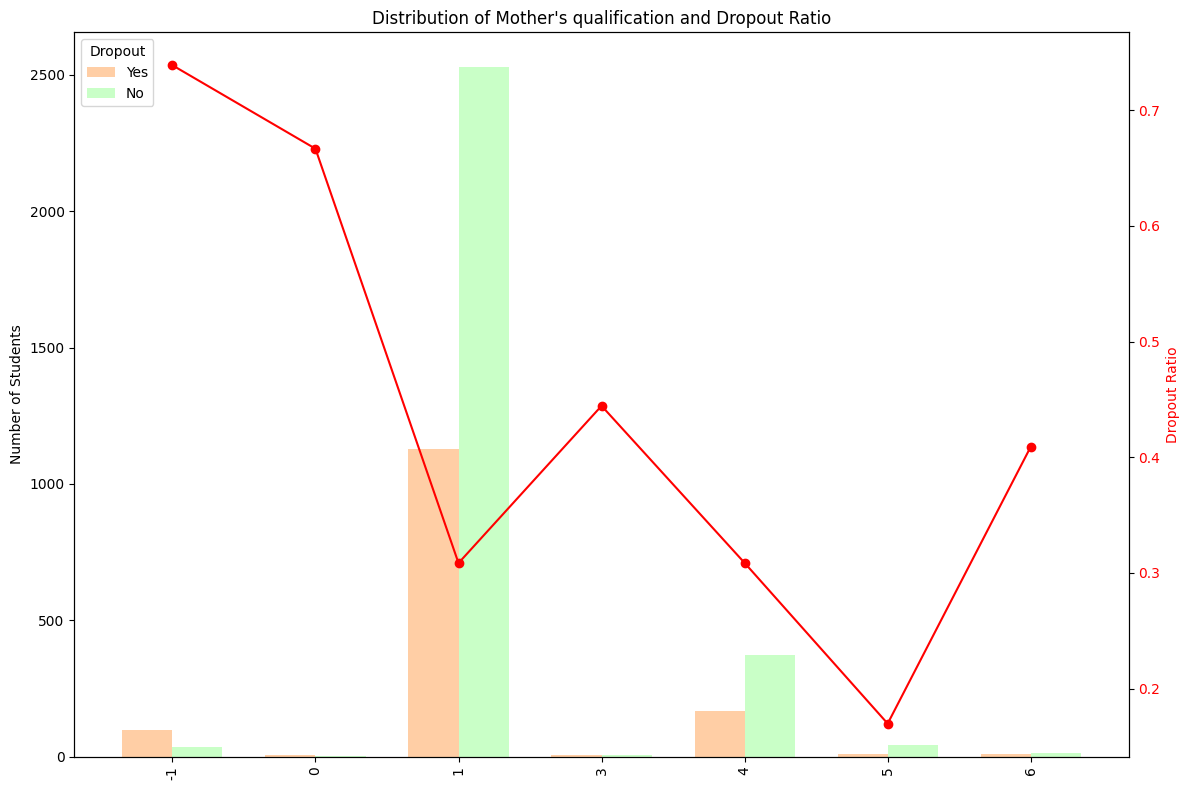

In [17]:
feature_name = "Father's qualification"
plot_feature(feature_name, qualification_groups, features_full)
feature_name = "Mother's qualification"
plot_feature(feature_name, qualification_groups, features_full)

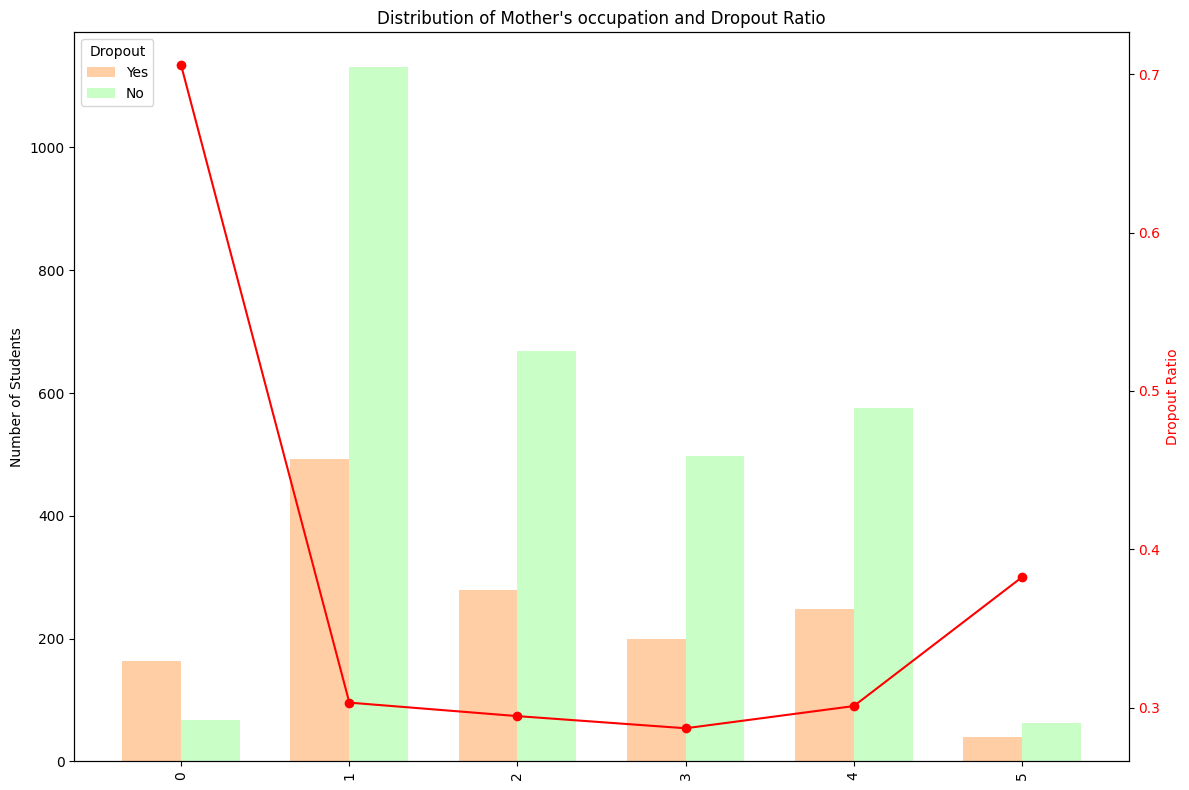

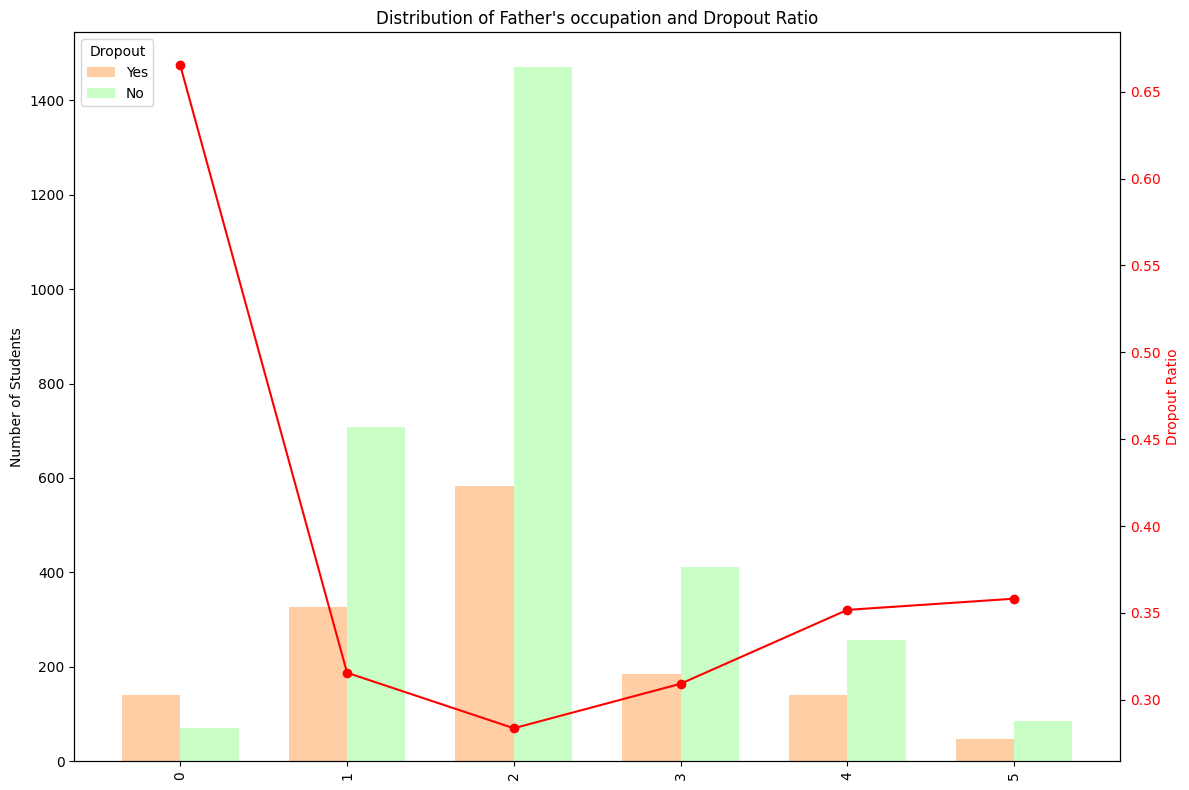

In [18]:
feature_name = "Mother's occupation"
plot_feature(feature_name, occupation_worker_levels, features_full)
feature_name = "Father's occupation"
plot_feature(feature_name, occupation_worker_levels, features_full)

## Correlations

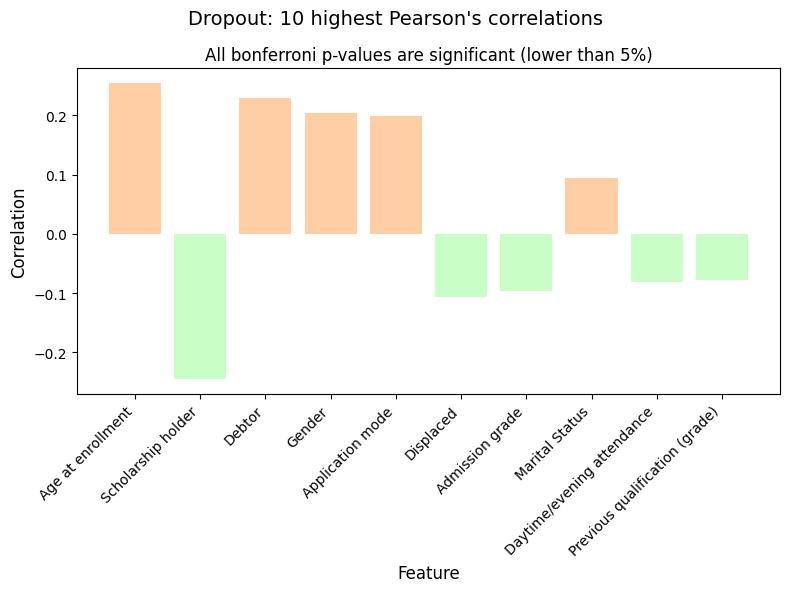

In [19]:
plot_corr(features_full,feature_cols=['Dropout'], show_specific_features=True)

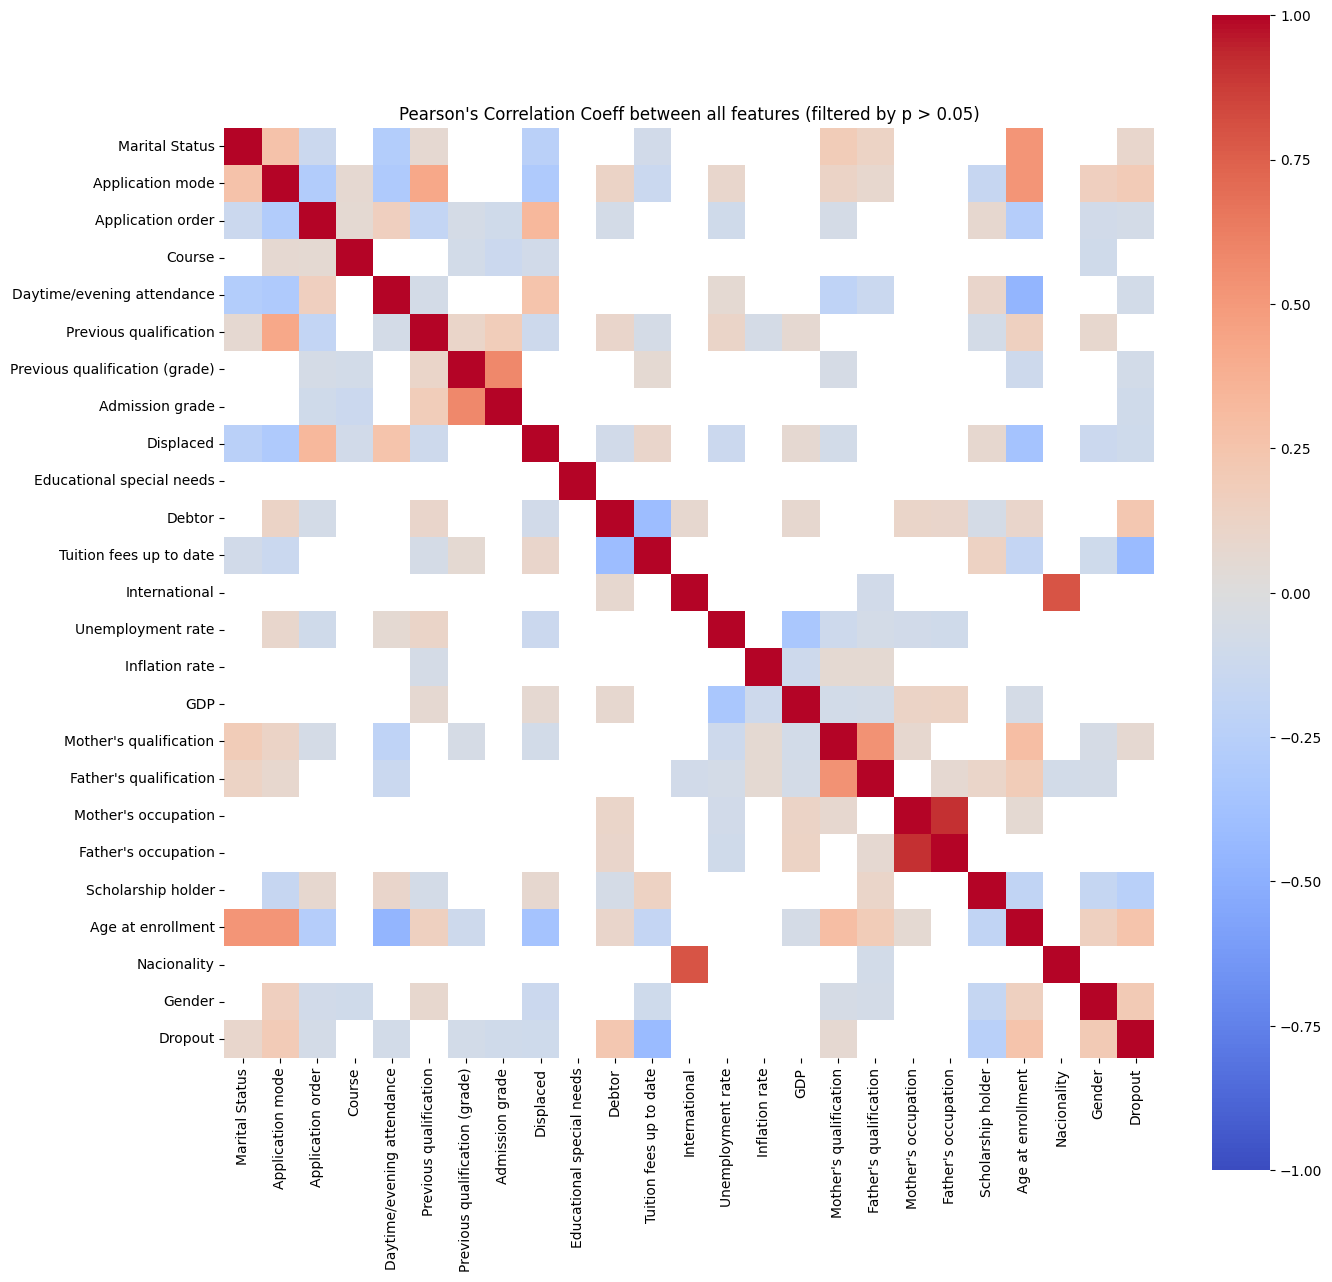

In [20]:
plot_corr(features_full)

# Baseline Model

In [21]:
logreg = LogisticRegression(max_iter=1000, random_state=seed)
RFclf = RandomForestClassifier(max_depth=5,
                                random_state=seed,
                                n_jobs=-1,
                                n_estimators=200)

## Logistic Regression (White-box Model)

In [22]:
logreg_preds = cross_validator(logreg, X_train, y_train, debias=False)


print("classification report on training data:\n",classification_report(y_train, logreg_preds))


log_metric_score = metric_scores(y_test=y_train, y_pred = logreg_preds, group_test=group_train)
log_metric_df = metric_df(log_metric_score, group_names=["Female", "Male"], names=metric_names)


log_metric_df

classification report on training data:
               precision    recall  f1-score   support

           0       0.77      0.93      0.85      2402
           1       0.75      0.42      0.54      1137

    accuracy                           0.77      3539
   macro avg       0.76      0.68      0.69      3539
weighted avg       0.76      0.77      0.75      3539



,score,metric,group
0,0.180064,stat_parity,Female
1,0.181070,stat_parity,Male
2,0.174840,odds_t0,Female
3,0.186090,odds_t0,Male
4,0.196078,odds_t1,Female
5,0.175000,odds_t1,Male
6,0.241176,outcome_s0,Female
7,0.456030,outcome_s0,Male
8,0.267857,outcome_s1,Female
9,0.437500,outcome_s1,Male


## Random Forest (Black-box Model)

In [23]:
RFclf_preds = cross_validator(RFclf, X_train, y_train, debias=False)

RFclf.fit(X_train, y_train)
RFclf_preds_test = RFclf.predict(X_test)
print(classification_report(y_test, RFclf_preds_test))

RF_metric_score = metric_scores(y_test=y_test, y_pred=RFclf_preds_test, group_test=group_test)
RF_metric_df = metric_df(RF_metric_score, group_names=["Female", "Male"], names=metric_names)

RF_metric_df

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       601
           1       0.82      0.37      0.51       284

    accuracy                           0.77       885
   macro avg       0.79      0.66      0.68       885
weighted avg       0.78      0.77      0.74       885



,score,metric,group
0,0.209677,stat_parity,Female
1,0.122807,stat_parity,Male
2,0.230769,odds_t0,Female
3,0.142857,odds_t0,Male
4,0.151515,odds_t1,Female
5,0.090909,odds_t1,Male
6,0.285714,outcome_s0,Female
7,0.400000,outcome_s0,Male
8,0.192308,outcome_s1,Female
9,0.285714,outcome_s1,Male


## Compare Logistic Regression and Random Forest Classification

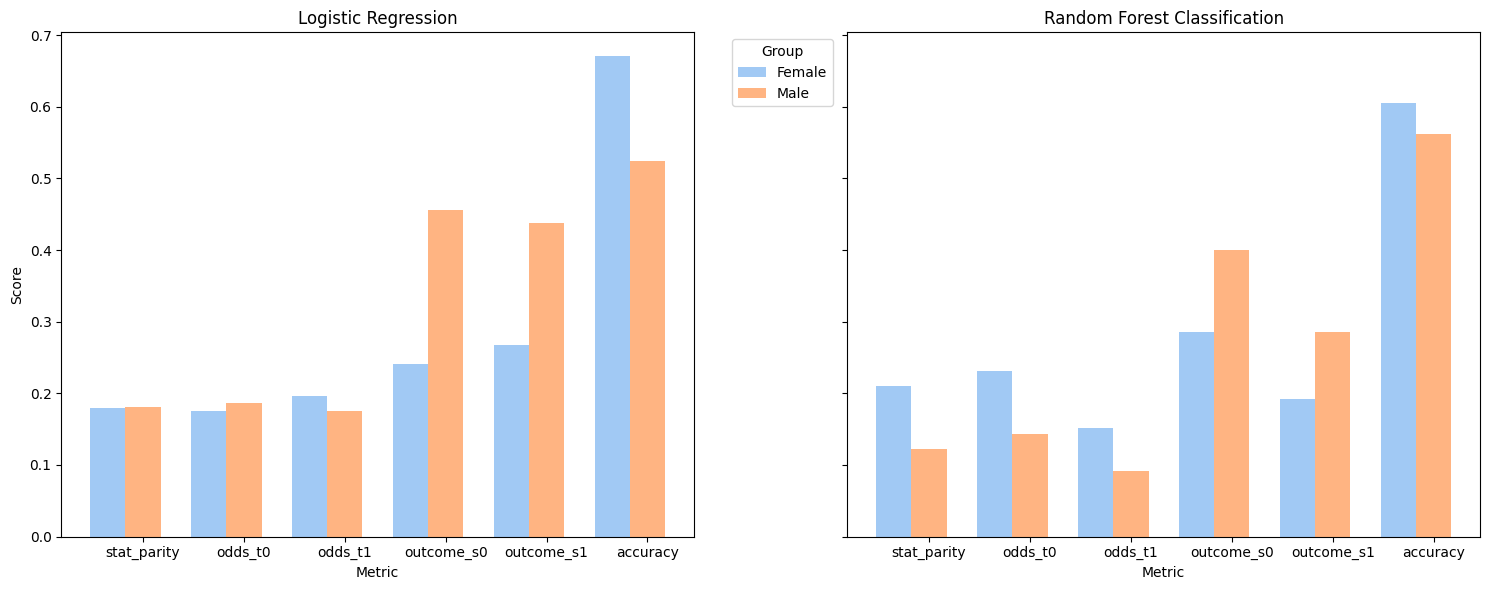

In [24]:
plot_scores_and_group_compare(log_metric_df, RF_metric_df, titles=['Logistic Regression','Random Forest Classification'])

# Debias Data and Model Performance

## Logistic Regression (White-box Model)

In [25]:
logreg_preds = cross_validator(logreg, X_train, y_train, protected_cols, debias=True) # TODO: should we use the whole dataset instead of just training? This also apply to the section Baseline Model and...

print(classification_report(y_train, logreg_preds))
log_metric_score = metric_scores(y_test=y_train, y_pred=logreg_preds, group_test=group_train)
debiased_log_metric_df = metric_df(log_metric_score, group_names=["Female", "Male"], names=metric_names)

debiased_log_metric_df

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2402
           1       0.76      0.39      0.51      1137

    accuracy                           0.76      3539
   macro avg       0.76      0.66      0.68      3539
weighted avg       0.76      0.76      0.74      3539



,score,metric,group
0,0.162915,stat_parity,Female
1,0.160494,stat_parity,Male
2,0.157072,odds_t0,Female
3,0.176692,odds_t0,Male
4,0.180828,odds_t1,Female
5,0.140909,odds_t1,Male
6,0.240717,outcome_s0,Female
7,0.463235,outcome_s0,Male
8,0.273026,outcome_s1,Female
9,0.397436,outcome_s1,Male


## Random Forest Classification (Black-box Model)

In [26]:
RFclf_preds = cross_validator(RFclf, X_train, y_train, protected_cols, debias=True)


print(classification_report(y_train, RFclf_preds))
RF_metric_score = metric_scores(y_test=y_train, y_pred=RFclf_preds, group_test=group_train)
debiased_RF_metric_df = metric_df(log_metric_score, group_names=["Female", "Male"], names=metric_names)


debiased_RF_metric_df

              precision    recall  f1-score   support

           0       0.76      0.98      0.85      2402
           1       0.90      0.33      0.48      1137

    accuracy                           0.77      3539
   macro avg       0.83      0.66      0.67      3539
weighted avg       0.80      0.77      0.74      3539



,score,metric,group
0,0.162915,stat_parity,Female
1,0.160494,stat_parity,Male
2,0.157072,odds_t0,Female
3,0.176692,odds_t0,Male
4,0.180828,odds_t1,Female
5,0.140909,odds_t1,Male
6,0.240717,outcome_s0,Female
7,0.463235,outcome_s0,Male
8,0.273026,outcome_s1,Female
9,0.397436,outcome_s1,Male


## Compare Debiased Models

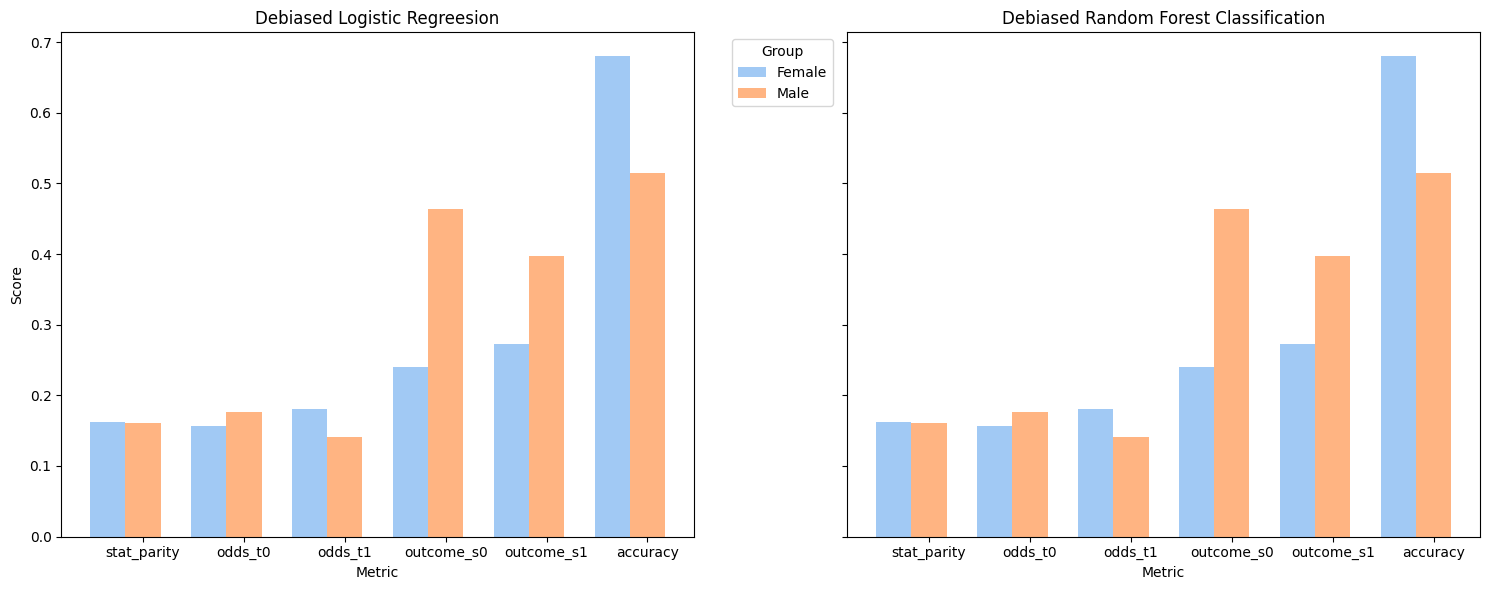

In [27]:
plot_scores_and_group_compare(debiased_log_metric_df, debiased_RF_metric_df, titles=["Debiased Logistic Regreesion", "Debiased Random Forest Classification"])

## Orginal data vs. Debiased data



### Logistic Regression

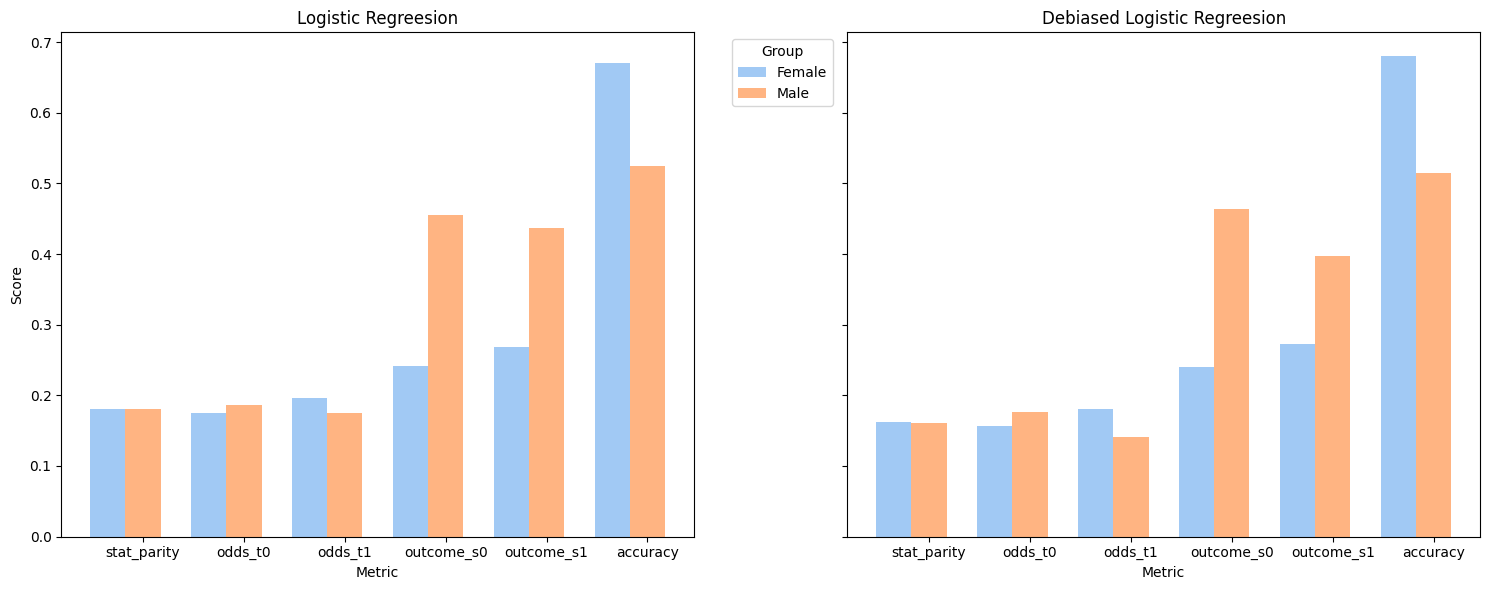

In [28]:
plot_scores_and_group_compare(log_metric_df, debiased_log_metric_df, titles=["Logistic Regreesion", "Debiased Logistic Regreesion"])

### Random Forest Classification

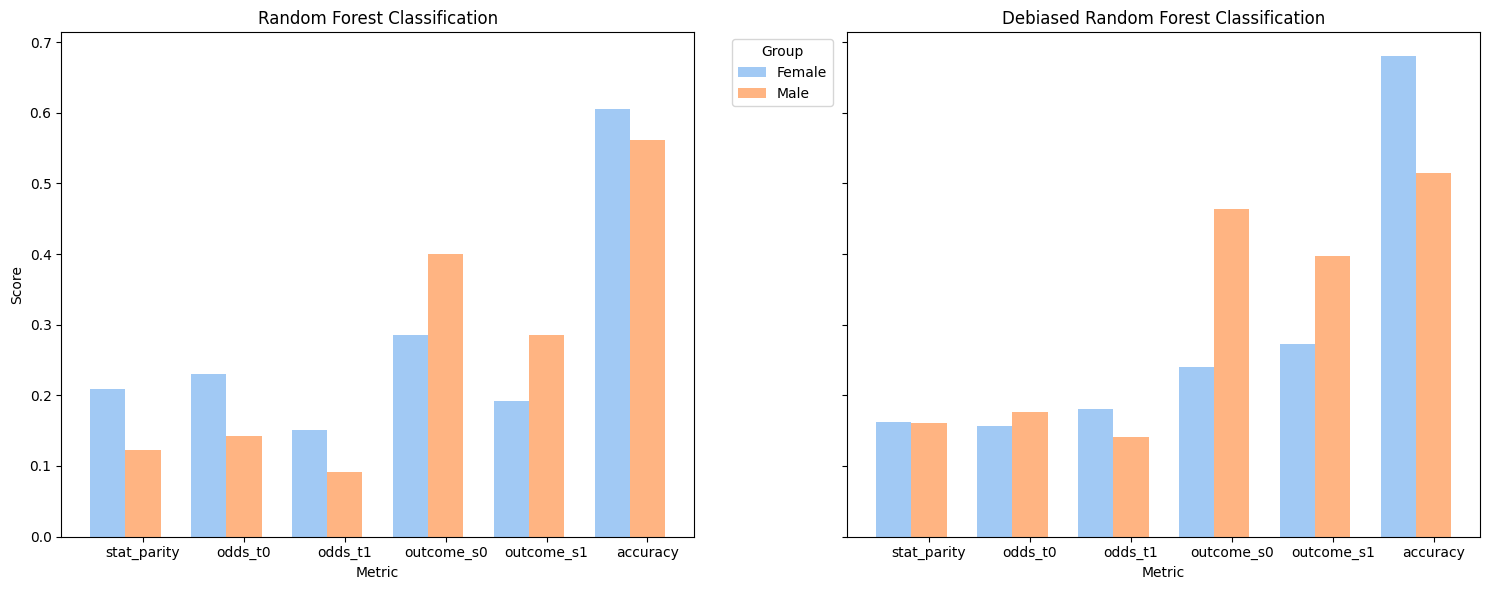

In [29]:
plot_scores_and_group_compare(RF_metric_df, debiased_RF_metric_df, titles=["Random Forest Classification", "Debiased Random Forest Classification"])

# Try things out...

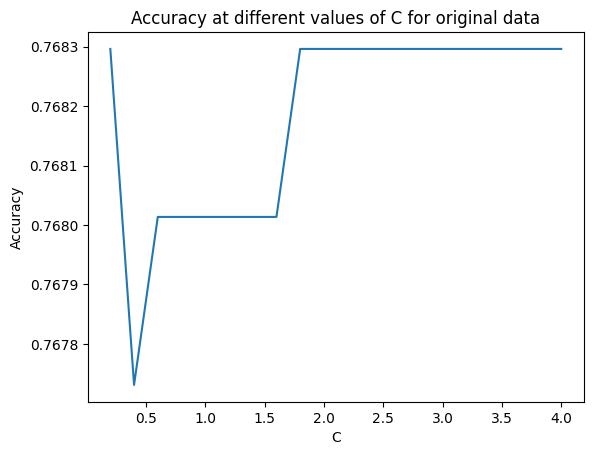

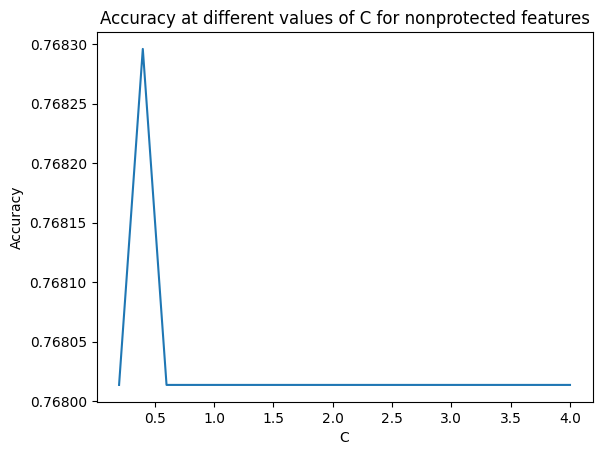

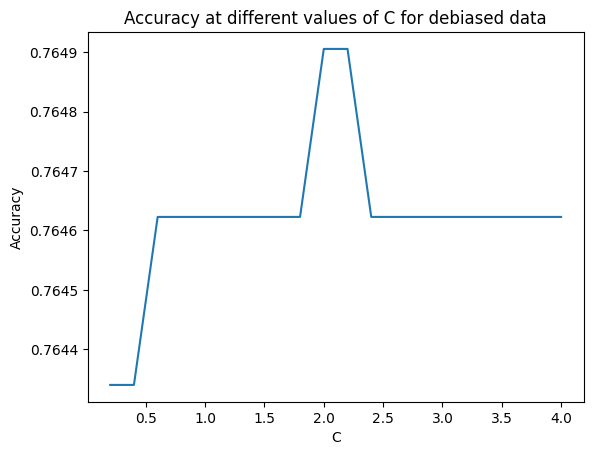

In [30]:
## TODO: something seems to be wrong also here..
## TODO: if this is going to be used, then make a function...??
# Define model

# Find optimal C
descriptions = ['original data', 'nonprotected features', 'debiased data']
for desc in descriptions:
    depths = np.linspace(0.2,4,20)
    scores = []
    for i in depths:
      model = LogisticRegression(max_iter=5000, C=i,random_state=seed)
      preds = []
      if desc == 'original data':
        preds = cross_validator(model, X_train, y_train)
      elif desc == 'nonprotected features':
        preds = cross_validator(model, X_train_np, y_train)
      else:
        preds = cross_validator(model, X_train, y_train, protected_cols=protected_cols, debias=True)

      acc = accuracy_score(preds, y_train)
      scores.append(acc)

    # Plot accuracy at each value of C
    plt.plot(depths, scores)
    plt.title(f'Accuracy at different values of C for {desc}')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.show()

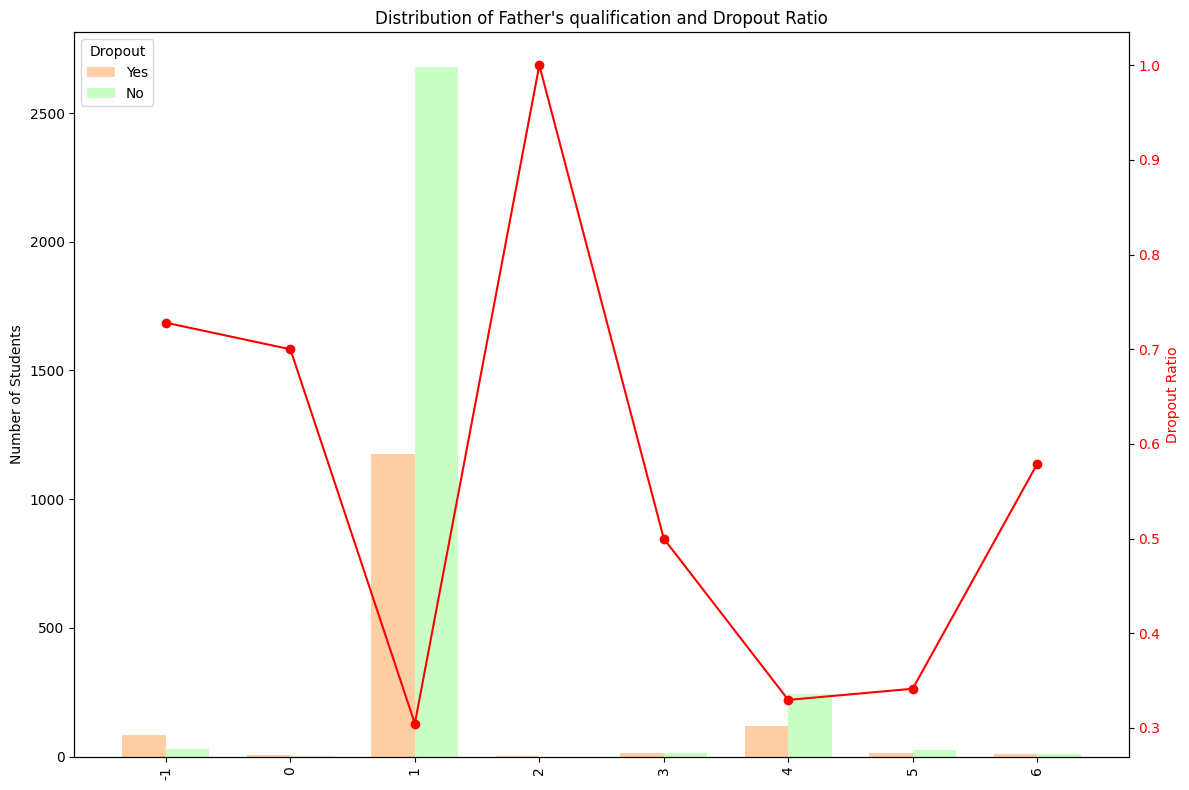

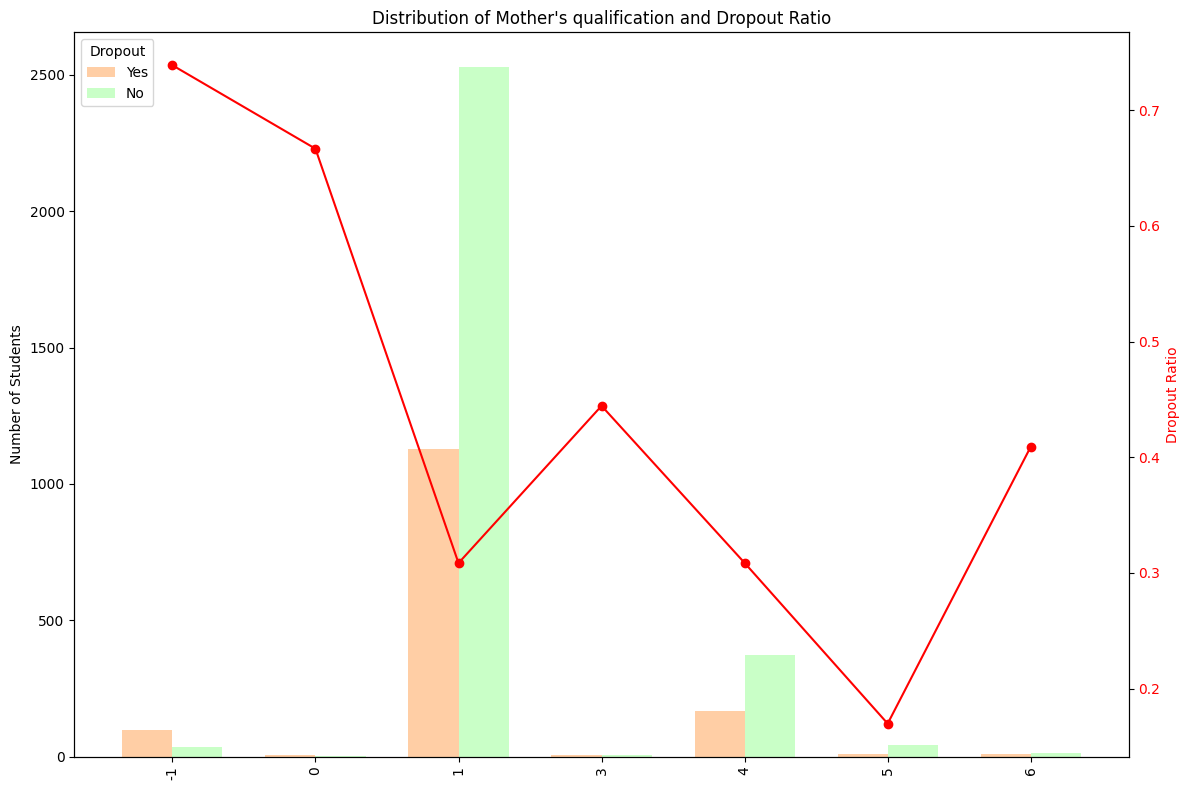

In [31]:
feature_name = "Mother's occupation"
#plot_feature(feature_name, occupation_worker_levels, features_full, column_feature='International', labels=['No', 'Yes'], show_ratio=False)
feature_name = "Father's occupation"
#plot_feature(feature_name, occupation_worker_levels, features_full, column_feature='Gender', colors=['pink', 'skyblue'], labels=['Female', 'Male'], show_ratio=False)

feature_name = "Father's qualification"
plot_feature(feature_name, qualification_groups, features_full)
feature_name = "Mother's qualification"
plot_feature(feature_name, qualification_groups, features_full)


feature_name = "Mother's occupation"
#plot_feature(feature_name, occupation_worker_levels, features_full)
feature_name = "Father's occupation"
#plot_feature(feature_name, occupation_worker_levels, features_full)

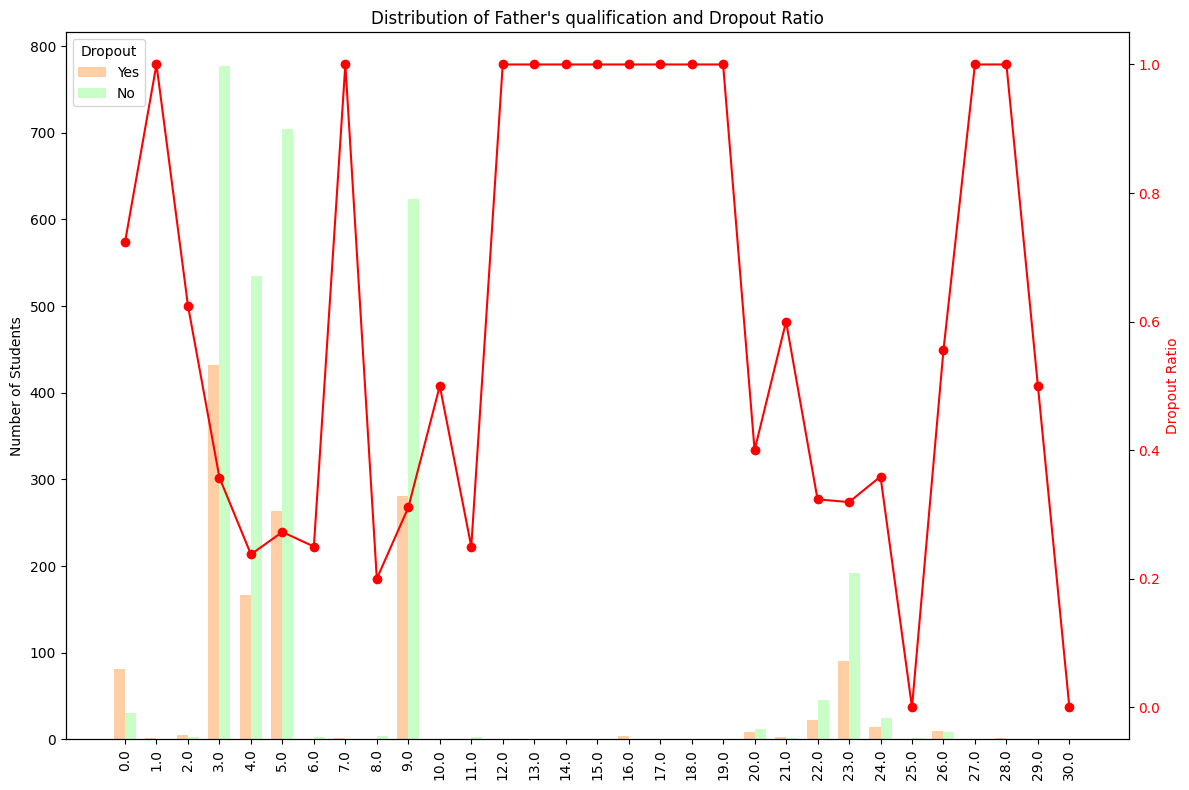

19

In [32]:
feature_name = "Mother's qualification"
#plot_feature(feature_name, education_levels, features_full)
feature_name = "Father's qualification"
plot_feature(feature_name, education_levels, features_full)
features_full[feature_name][27]

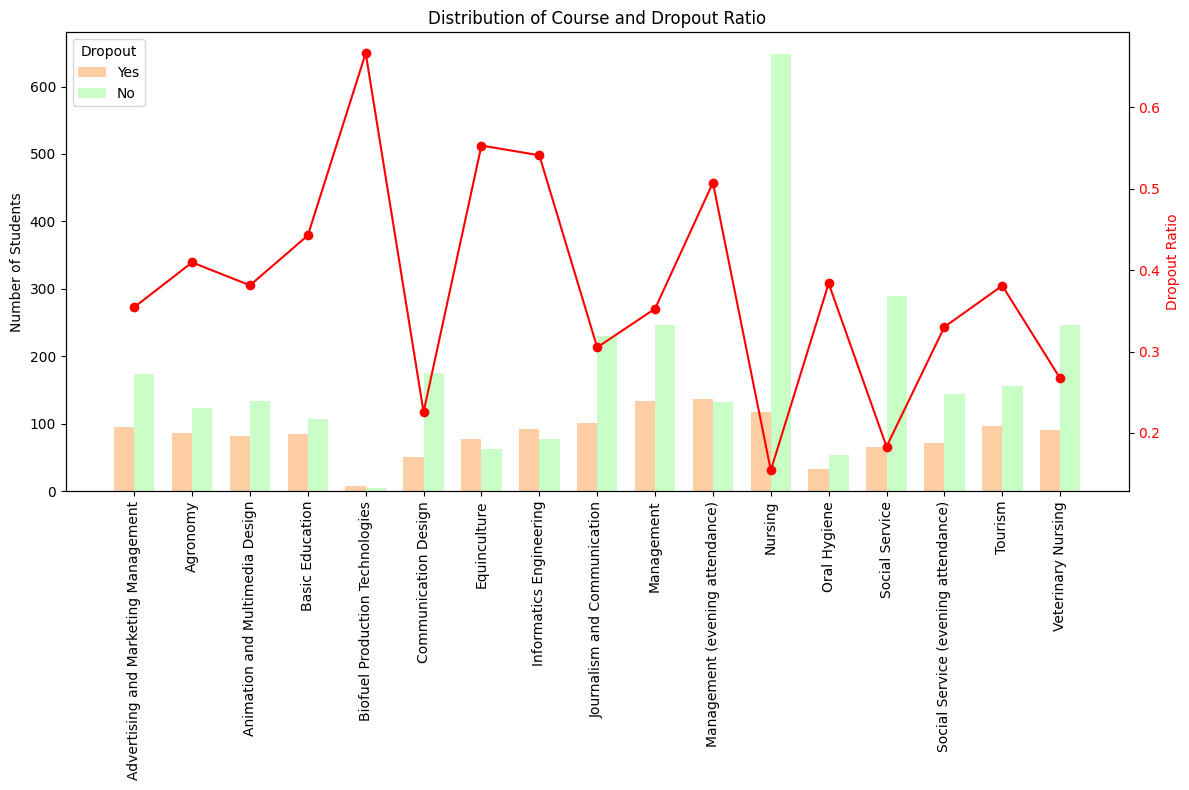

In [33]:
feature_name = "Course"
plot_feature(feature_name, course_names, features_full)

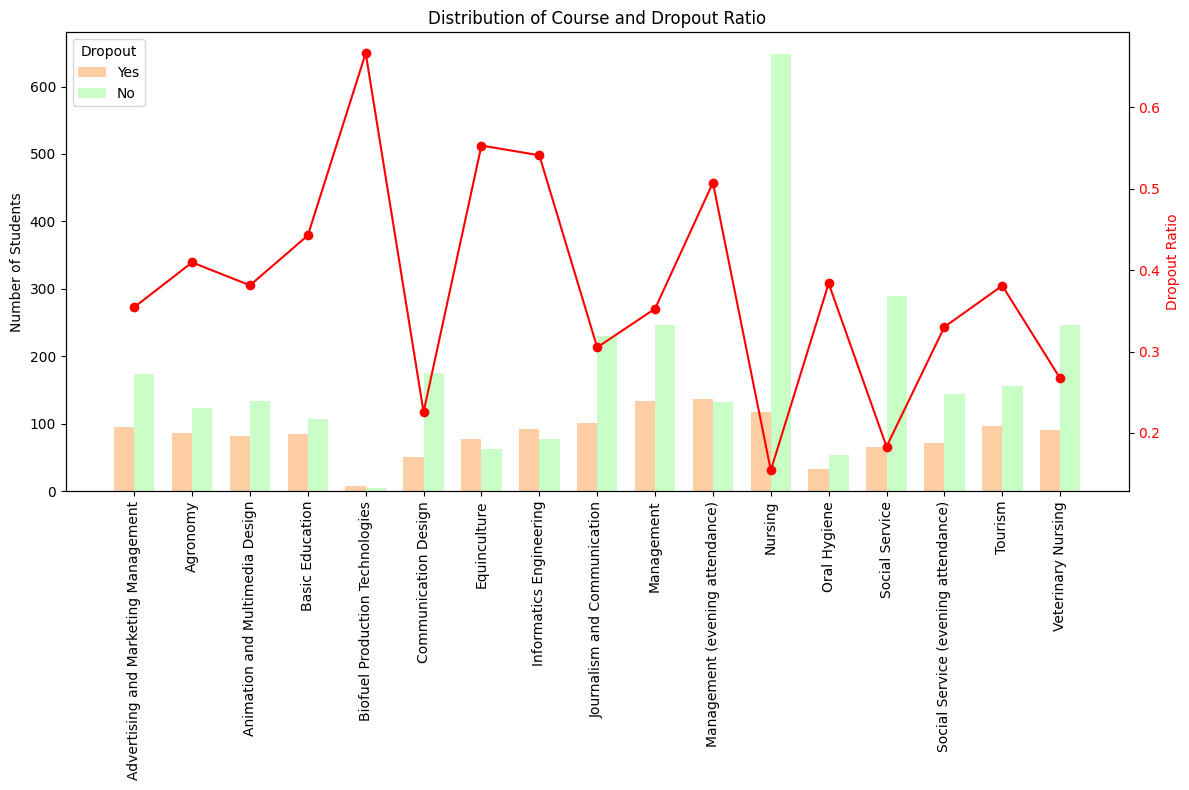

In [34]:
feature_name = "Course"
plot_feature(feature_name, course_names, features_full)

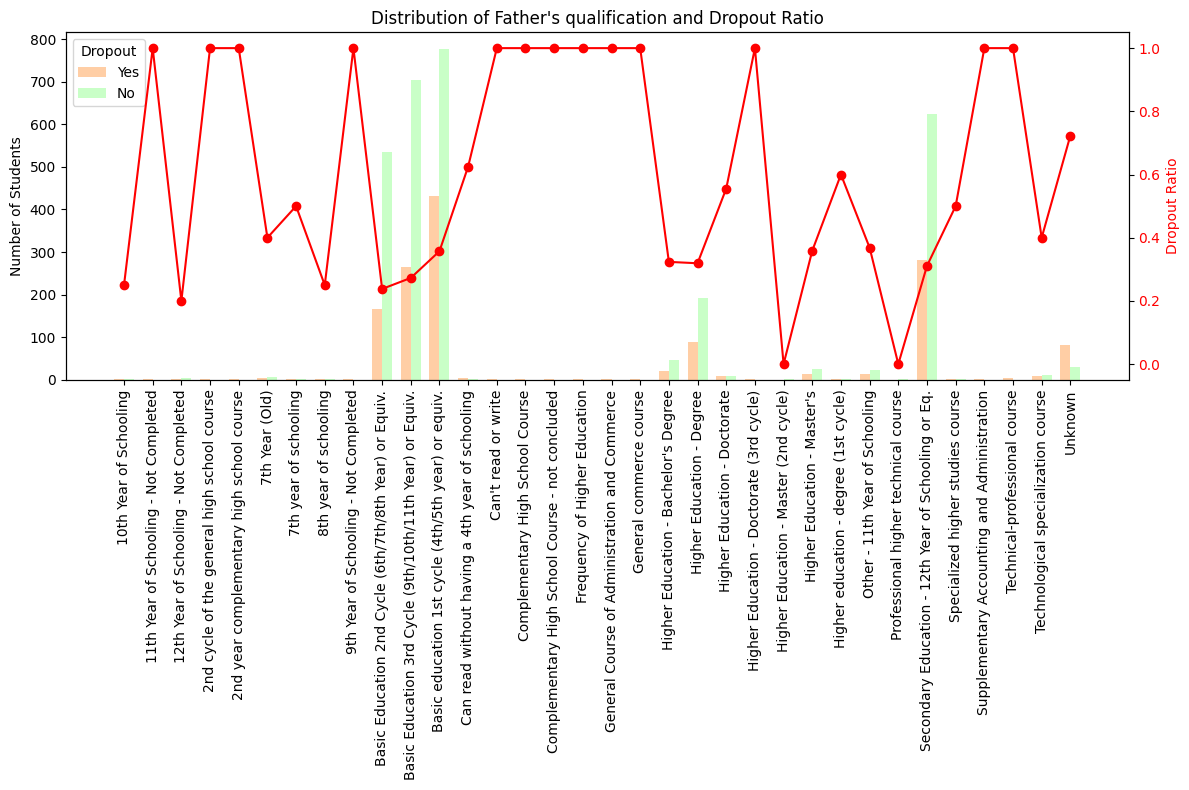

In [35]:
feature_name = "Father's qualification"
plot_feature(feature_name, qualification_names, features_full)

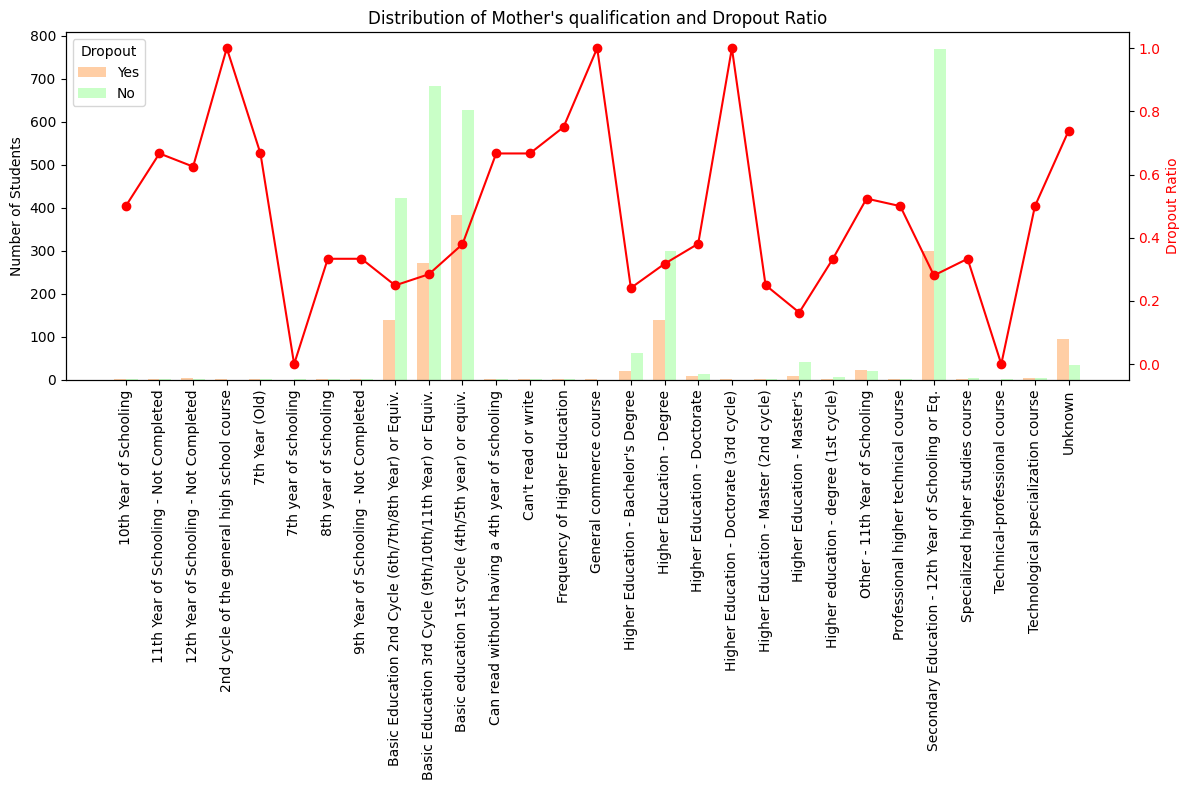

In [36]:
feature_name = "Mother's qualification"
plot_feature(feature_name, qualification_names, features_full)

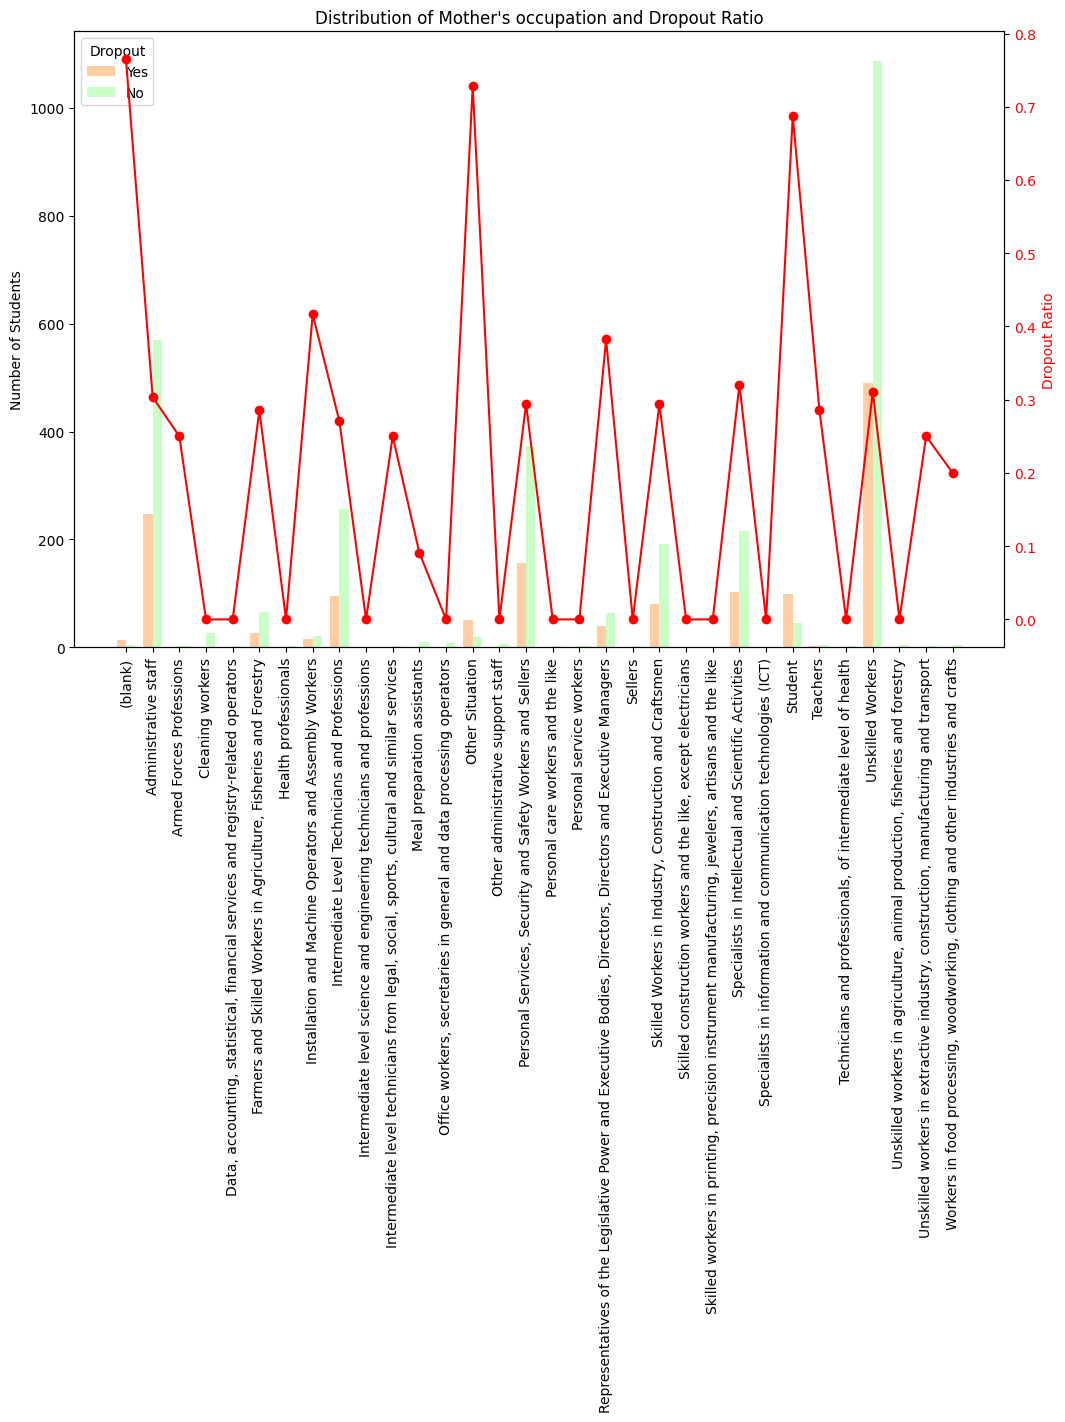

In [37]:
feature_name = "Mother's occupation"
plot_feature(feature_name, occupation_names, features_full)

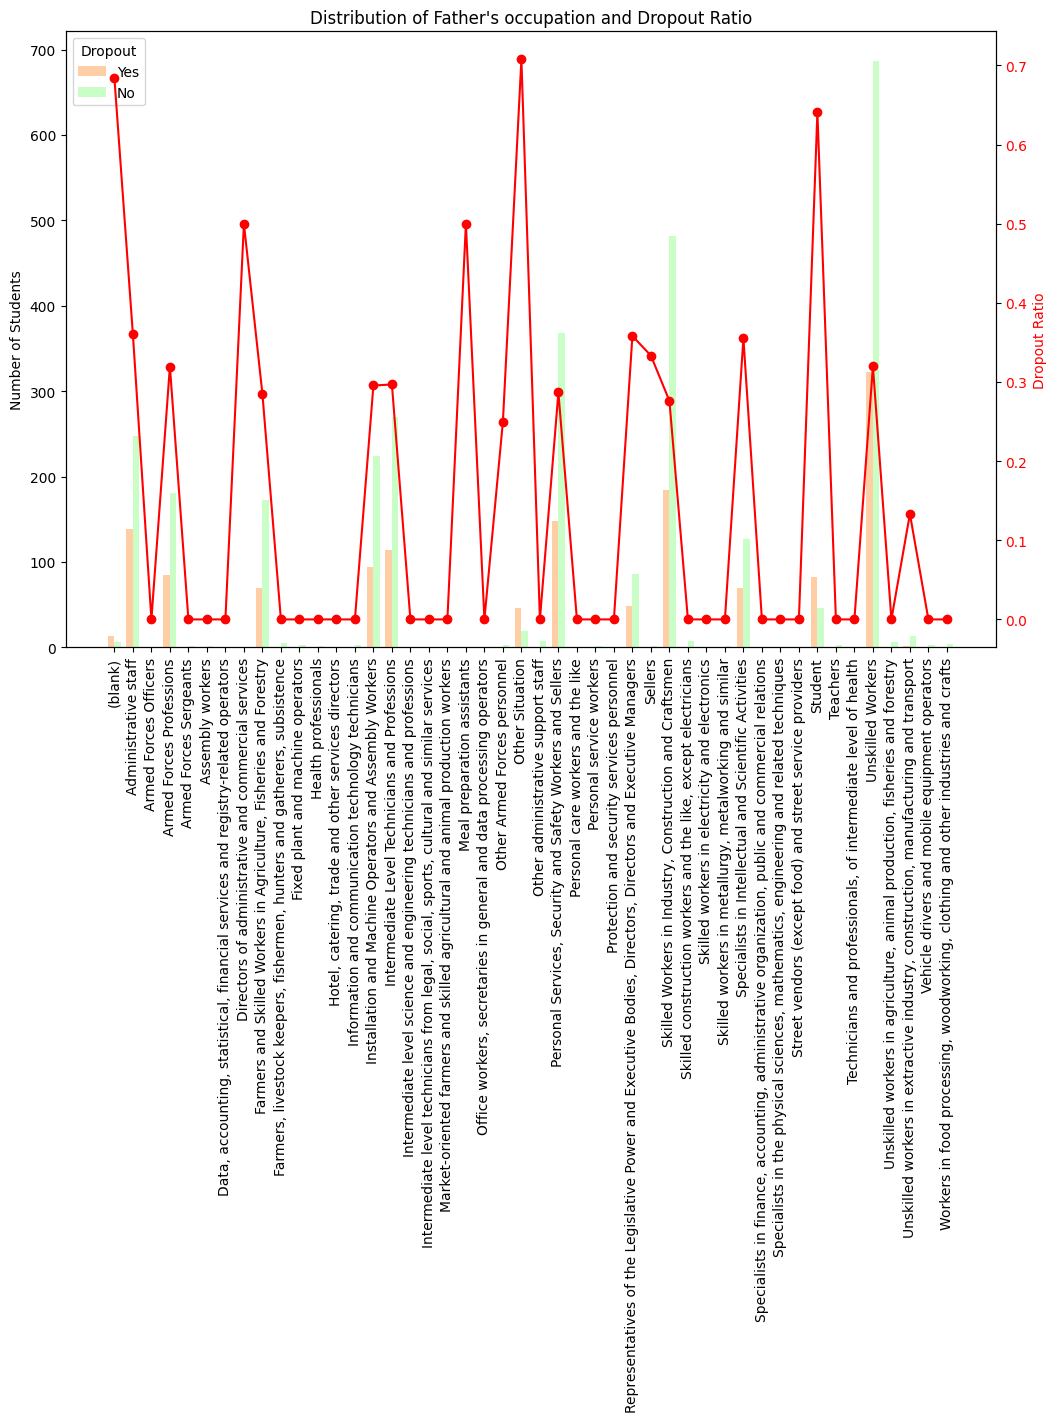

In [38]:
feature_name = "Father's occupation"
plot_feature(feature_name, occupation_names, features_full)

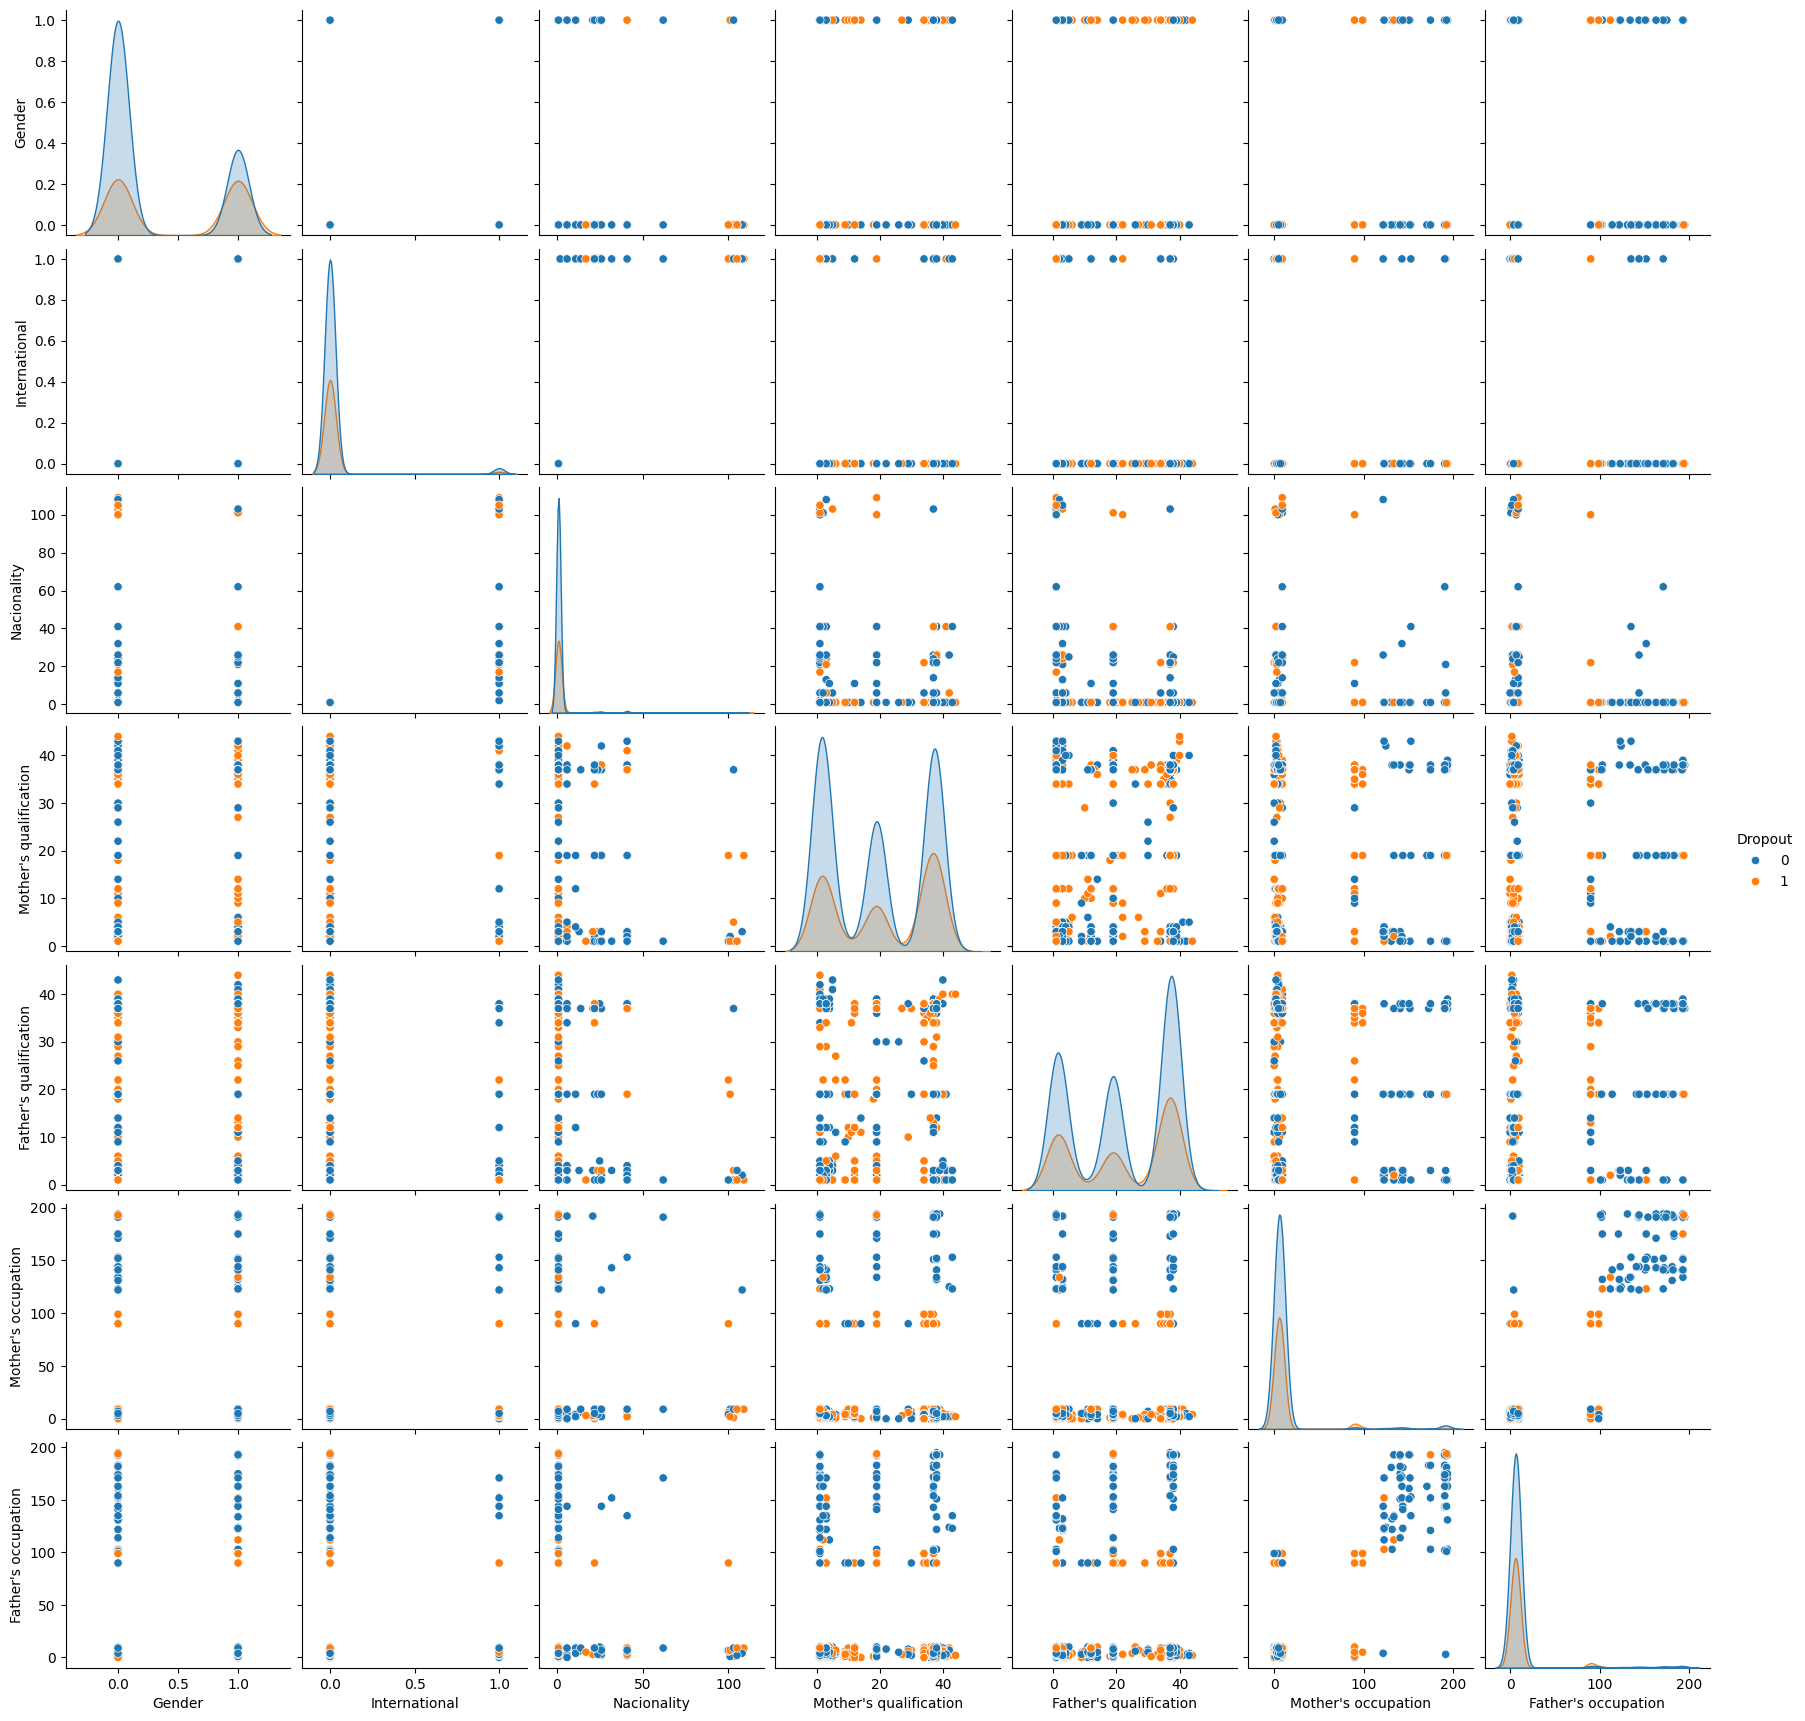

In [39]:
lst = ['Gender', 'International', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]
sns.pairplot(data=features_full, x_vars=lst, y_vars=lst, hue='Dropout', diag_kind='kde');

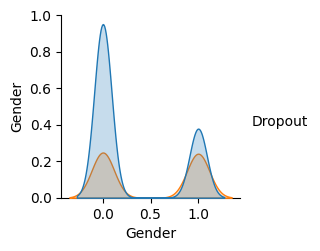

In [40]:
sns.pairplot(data=features_full, x_vars=protected_cols, y_vars=protected_cols, hue='Dropout', diag_kind='kde');

                Course
Gender Dropout        
0      0          2148
       1           720
1      0           855
       1           701


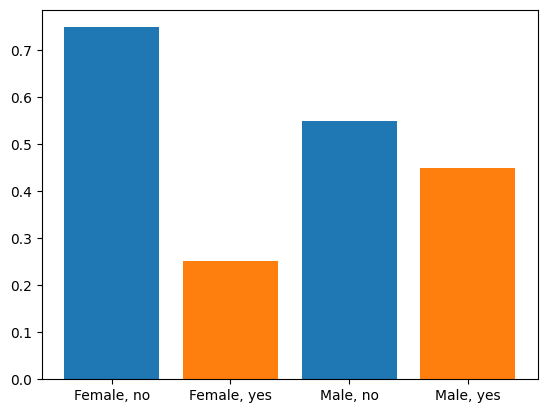

In [41]:
males = features_full[features_full.Gender==1].shape[0]
females = features_full[features_full.Gender==0].shape[0]

X = pd.DataFrame(features_full.groupby(['Gender', 'Dropout']).count().Course)

print(X)

plt.bar([0,1,2,3], X.Course/[females, females, males, males], color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.xticks([0,1,2,3],  labels=['Female, no', 'Female, yes','Male, no', 'Male, yes']);

                       Course
International Dropout        
0             0          2925
              1          1389
1             0            78
              1            32


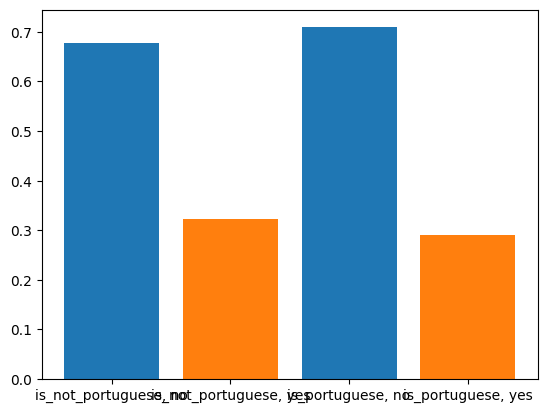

In [42]:
is_portuguese = features_full[features_full.International==1].shape[0]
is_not_portuguese = features_full[features_full.International==0].shape[0]

X = pd.DataFrame(features_full.groupby(['International', 'Dropout']).count().Course)

print(X)

plt.bar([0,1,2,3], X.Course/[is_not_portuguese, is_not_portuguese, is_portuguese, is_portuguese], color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.xticks([0,1,2,3],  labels=['is_not_portuguese, no', 'is_not_portuguese, yes','is_portuguese, no', 'is_portuguese, yes']);

                Course
Gender Dropout        
0      0          2148
       1           720
1      0           855
       1           701


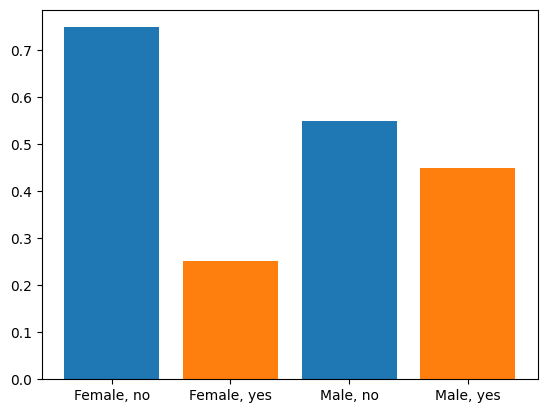

In [43]:
males = features_full[features_full.Gender==1].shape[0]
females = features_full[features_full.Gender==0].shape[0]

X = pd.DataFrame(features_full.groupby(['Gender', 'Dropout']).count().Course)

print(X)

plt.bar([0,1,2,3], X.Course/[females, females, males, males], color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.xticks([0,1,2,3],  labels=['Female, no', 'Female, yes','Male, no', 'Male, yes']);

In [ ]:
model = LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga")
#logreg_preds = cross_validator(model, X_train, y_train, debias=False)
logreg_preds = cross_validator(model, X_train, y_train, protected_cols, debias=False)
logreg_preds

In [ ]:
plot_corr(features_full,feature_cols=['Dropout'], show_specific_features=True)

In [ ]:
plot_corr(features_full,feature_cols=['Educational special needs'], show_specific_features=True)
plot_corr(features_full,feature_cols=["Father's occupation"], show_specific_features=True)
plot_corr(features_full,feature_cols=["Admission grade"], show_specific_features=True)
plot_corr(features_full, method='spearman')